In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, anderson, kstest
from scipy.stats import pearsonr, spearmanr, kendalltau
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Set style for beautiful plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

In [3]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the data
df = pd.read_csv("data_ggl.csv")

### DATASET OVERVIEW AND STRUCTURE

In [4]:
print(f"\n{'Dataset Dimensions:':<30} {df.shape[0]} rows × {df.shape[1]} columns")
print(f"{'Total Data Points:':<30} {df.shape[0] * df.shape[1]}")
print(f"{'Memory Usage:':<30} {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"{'Time Span:':<30} Day {df['Days'].min()} to Day {df['Days'].max()} ({df['Days'].max() - df['Days'].min()} days)")
print(f"{'Sampling Frequency:':<30} Every {df['Days'].diff().mode()[0]:.0f} days (approximately)")

print("\n" + "-"*100)
print("COLUMN INFORMATION:")
print("-"*100)
print(f"\n{'Column Name':<45} {'Data Type':<15} {'Non-Null':<10} {'Unique Values'}")
print("-"*100)
for col in df.columns:
    print(f"{col:<45} {str(df[col].dtype):<15} {df[col].notna().sum():<10} {df[col].nunique()}")

print("\n" + "-"*100)
print("FEATURE CATEGORIES:")
print("-"*100)
feature_groups = {
    'Temporal': ['Days'],
    'pH Measurements': [col for col in df.columns if 'pH' in col],
    'Alkalinity Measurements': [col for col in df.columns if 'Alkalinity' in col],
    'Nitrate Measurements': [col for col in df.columns if 'Nitrate' in col],
    'Ammonium Measurements': [col for col in df.columns if 'Ammonium' in col],
    'Target Variable': ['TMP_cmHg']
}

for category, features in feature_groups.items():
    print(f"\n{category}: {len(features)} feature(s)")
    for feat in features:
        print(f"  - {feat}")


Dataset Dimensions:            50 rows × 18 columns
Total Data Points:             900
Memory Usage:                  7.16 KB
Time Span:                     Day 12 to Day 180 (168 days)
Sampling Frequency:            Every 3 days (approximately)

----------------------------------------------------------------------------------------------------
COLUMN INFORMATION:
----------------------------------------------------------------------------------------------------

Column Name                                   Data Type       Non-Null   Unique Values
----------------------------------------------------------------------------------------------------
Days                                          int64           50         50
pH_Influent                                   float64         50         18
pH_Anoxic                                     float64         50         19
pH_MBR                                        float64         50         15
pH_Effluent                          

### DATA QUALITY ASSESSMENT

In [5]:
print("MISSING VALUES ANALYSIS:")
print("-"*100)
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_summary)
print(f"\n✓ CONCLUSION: {missing_summary['Missing_Count'].sum()} missing values found (Perfect data quality)")

print("\n" + "-"*100)
print("DUPLICATE RECORDS ANALYSIS:")
print("-"*100)
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")
if duplicates > 0:
    print("\nDuplicate rows:")
    print(df[df.duplicated(keep=False)])
else:
    print("✓ CONCLUSION: No duplicate records found")

print("\n" + "-"*100)
print("DATA TYPE CONSISTENCY:")
print("-"*100)
expected_types = {
    'Days': 'int64',
    'TMP_cmHg': 'float64'
}
type_issues = []
for col, expected in expected_types.items():
    if col in df.columns:
        actual = str(df[col].dtype)
        match = "✓" if actual == expected else "✗"
        print(f"{match} {col:<30} Expected: {expected:<15} Actual: {actual}")
        if actual != expected:
            type_issues.append(col)

if type_issues:
    print(f"\n⚠ WARNING: {len(type_issues)} columns have unexpected data types")
else:
    print("\n✓ CONCLUSION: All data types are as expected")

MISSING VALUES ANALYSIS:
----------------------------------------------------------------------------------------------------
                               Missing_Count  Missing_Percentage
Days                                       0                 0.0
pH_Influent                                0                 0.0
pH_Anoxic                                  0                 0.0
pH_MBR                                     0                 0.0
pH_Effluent                                0                 0.0
Alkalinity_Influent_mgCaCO3_L              0                 0.0
Alkalinity_Anoxic_mgCaCO3_L                0                 0.0
Alkalinity_MBR_mgCaCO3_L                   0                 0.0
Alkalinity_Effluent_mgCaCO3_L              0                 0.0
Nitrate_Influent_mg_L                      0                 0.0
Nitrate_Anoxic_mg_L                        0                 0.0
Nitrate_MBR_mg_L                           0                 0.0
Nitrate_Effluent_mg_L        

### DESCRIPTIVE STATISTICS - DEEP DIVE


In [6]:
print("COMPREHENSIVE STATISTICAL SUMMARY:")
print("-"*100)
desc = df.describe(percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99]).T
desc['range'] = desc['max'] - desc['min']
desc['iqr'] = desc['75%'] - desc['25%']
desc['cv'] = (desc['std'] / desc['mean'] * 100).round(2)  # Coefficient of variation
print(desc.to_string())

print("\n" + "-"*100)
print("VARIABILITY ANALYSIS (Coefficient of Variation):")
print("-"*100)
cv_analysis = pd.DataFrame({
    'Feature': df.columns[1:],
    'CV%': [(df[col].std() / df[col].mean() * 100) for col in df.columns[1:]]
}).sort_values('CV%', ascending=False)
print(cv_analysis.to_string(index=False))
print("\nInterpretation:")
print("  - CV < 10%: Low variability")
print("  - CV 10-20%: Moderate variability")
print("  - CV > 20%: High variability")

COMPREHENSIVE STATISTICAL SUMMARY:
----------------------------------------------------------------------------------------------------
                               count       mean        std     min        1%        5%      10%       25%      50%       75%      90%       95%       99%     max   range      iqr     cv
Days                            50.0   97.12000  50.430247   12.00   13.4700   20.3500   28.700   54.7500   97.500  140.2500  164.200  171.2000  178.0400  180.00  168.00  85.5000  51.93
pH_Influent                     50.0    7.51260   0.071623    7.36    7.3698    7.4200    7.420    7.4600    7.530    7.5600    7.601    7.6200    7.6604    7.68    0.32   0.1000   0.95
pH_Anoxic                       50.0    7.34820   0.057594    7.24    7.2449    7.2545    7.279    7.3050    7.345    7.3875    7.430    7.4410    7.4551    7.46    0.22   0.0825   0.78
pH_MBR                          50.0    7.26320   0.036334    7.16    7.1698    7.1990    7.220    7.2425    7.260    7.

### DISTRIBUTION ANALYSIS

In [13]:
print("SKEWNESS AND KURTOSIS ANALYSIS:")
print("-"*100)
dist_stats = pd.DataFrame({
    'Feature': df.columns[1:],
    'Skewness': [df[col].skew() for col in df.columns[1:]],
    'Kurtosis': [df[col].kurtosis() for col in df.columns[1:]]
})
dist_stats['Interpretation'] = ''

for idx, row in dist_stats.iterrows():
    skew = row['Skewness']
    kurt = row['Kurtosis']
    
    if abs(skew) < 0.5:
        skew_interp = "Fairly symmetric"
    elif abs(skew) < 1:
        skew_interp = "Moderately skewed"
    else:
        skew_interp = "Highly skewed"
    
    if abs(kurt) < 0.5:
        kurt_interp = "Normal-like"
    elif kurt > 0.5:
        kurt_interp = "Heavy-tailed"
    else:
        kurt_interp = "Light-tailed"
    
    dist_stats.at[idx, 'Interpretation'] = f"{skew_interp}, {kurt_interp}"

print(dist_stats.to_string(index=False))

print("\n" + "-"*100)
print("NORMALITY TESTS (p-value > 0.05 suggests normality):")
print("-"*100)
normality_results = []
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Days':
        # Shapiro-Wilk test
        shapiro_stat, shapiro_p = shapiro(df[col])
        
        # D'Agostino's K-squared test
        try:
            k2_stat, k2_p = normaltest(df[col])
        except:
            k2_stat, k2_p = np.nan, np.nan
        
        # Anderson-Darling test
        anderson_result = anderson(df[col])
        anderson_stat = anderson_result.statistic
        
        normality_results.append({
            'Feature': col,
            'Shapiro_p': shapiro_p,
            'K2_p': k2_p,
            'Anderson_stat': anderson_stat,
            'Is_Normal': 'Yes' if shapiro_p > 0.05 else 'No'
        })

norm_df = pd.DataFrame(normality_results)
print(norm_df.to_string(index=False))

SKEWNESS AND KURTOSIS ANALYSIS:
----------------------------------------------------------------------------------------------------
                      Feature  Skewness  Kurtosis                  Interpretation
                  pH_Influent  0.028554 -0.556624  Fairly symmetric, Light-tailed
                    pH_Anoxic  0.088685 -0.772896  Fairly symmetric, Light-tailed
                       pH_MBR -0.513501  0.626644 Moderately skewed, Heavy-tailed
                  pH_Effluent  0.070052 -0.014333   Fairly symmetric, Normal-like
Alkalinity_Influent_mgCaCO3_L  0.014731 -0.971339  Fairly symmetric, Light-tailed
  Alkalinity_Anoxic_mgCaCO3_L  0.176753 -0.400148   Fairly symmetric, Normal-like
     Alkalinity_MBR_mgCaCO3_L -0.392975 -0.590327  Fairly symmetric, Light-tailed
Alkalinity_Effluent_mgCaCO3_L -0.831835 -0.011264  Moderately skewed, Normal-like
        Nitrate_Influent_mg_L  0.591385 -0.358579  Moderately skewed, Normal-like
          Nitrate_Anoxic_mg_L  0.484546 -1.0336

### OUTLIER DETECTION - MULTIPLE METHODS


In [12]:
print("METHOD 1: IQR METHOD (Tukey's Fences):")
print("-"*100)
outlier_summary = []
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Days':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_fence) | (df[col] > upper_fence)]
        
        outlier_summary.append({
            'Feature': col,
            'Lower_Fence': lower_fence,
            'Upper_Fence': upper_fence,
            'Outliers_Count': len(outliers),
            'Outliers_Pct': round(len(outliers) / len(df) * 100, 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

print("\n" + "-"*100)
print("METHOD 2: Z-SCORE METHOD (|Z| > 3):")
print("-"*100)
zscore_outliers = []
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Days':
        z_scores = np.abs(stats.zscore(df[col]))
        outliers = df[z_scores > 3]
        
        zscore_outliers.append({
            'Feature': col,
            'Outliers_Count': len(outliers),
            'Outliers_Pct': round(len(outliers) / len(df) * 100, 2)
        })

zscore_df = pd.DataFrame(zscore_outliers)
print(zscore_df.to_string(index=False))


METHOD 1: IQR METHOD (Tukey's Fences):
----------------------------------------------------------------------------------------------------
                      Feature  Lower_Fence  Upper_Fence  Outliers_Count  Outliers_Pct
                  pH_Influent      7.31000      7.71000               0           0.0
                    pH_Anoxic      7.18125      7.51125               0           0.0
                       pH_MBR      7.18625      7.33625               2           4.0
                  pH_Effluent      7.17500      7.45500               0           0.0
Alkalinity_Influent_mgCaCO3_L    221.25000    283.25000               0           0.0
  Alkalinity_Anoxic_mgCaCO3_L    149.00000    185.00000               0           0.0
     Alkalinity_MBR_mgCaCO3_L    113.75000    151.75000               0           0.0
Alkalinity_Effluent_mgCaCO3_L     76.25000    130.25000               6          12.0
        Nitrate_Influent_mg_L     -0.45000      1.55000               0           0.0


### CORRELATION ANALYSIS - COMPREHENSIVE


In [9]:
numeric_df = df.select_dtypes(include=[np.number])

print("\n" + "-"*100)
print("PEARSON CORRELATION WITH TARGET (TMP_cmHg):")
print("-"*100)
target_corr = []
for col in numeric_df.columns:
    if col not in ['Days', 'TMP_cmHg']:
        corr, p_value = pearsonr(df[col], df['TMP_cmHg'])
        target_corr.append({
            'Feature': col,
            'Correlation': corr,
            'P_value': p_value,
            'Strength': 'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.4 else 'Weak',
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

target_corr_df = pd.DataFrame(target_corr).sort_values('Correlation', key=abs, ascending=False)
print(target_corr_df.to_string(index=False))

print("\n" + "-"*100)
print("SPEARMAN CORRELATION WITH TARGET (TMP_cmHg) - Non-parametric:")
print("-"*100)
spearman_corr = []
for col in numeric_df.columns:
    if col not in ['Days', 'TMP_cmHg']:
        corr, p_value = spearmanr(df[col], df['TMP_cmHg'])
        spearman_corr.append({
            'Feature': col,
            'Spearman_Rho': corr,
            'P_value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

spearman_df = pd.DataFrame(spearman_corr).sort_values('Spearman_Rho', key=abs, ascending=False)
print(spearman_df.to_string(index=False))

print("\n" + "-"*100)
print("TOP 10 INTER-FEATURE CORRELATIONS:")
print("-"*100)
corr_matrix = numeric_df.corr()
# Get upper triangle of correlation matrix
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.columns[i] != 'Days' and corr_matrix.columns[j] != 'Days':
            corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

top_corr = pd.DataFrame(corr_pairs).sort_values('Correlation', key=abs, ascending=False).head(10)
print(top_corr.to_string(index=False))


----------------------------------------------------------------------------------------------------
PEARSON CORRELATION WITH TARGET (TMP_cmHg):
----------------------------------------------------------------------------------------------------
                      Feature  Correlation      P_value Strength Significant
             Nitrate_MBR_mg_L    -0.779900 2.477184e-11   Strong         Yes
        Nitrate_Effluent_mg_L    -0.768572 7.185469e-11   Strong         Yes
Alkalinity_Effluent_mgCaCO3_L    -0.735797 1.147383e-09   Strong         Yes
       Ammonium_Influent_mg_L    -0.633868 7.752837e-07 Moderate         Yes
     Alkalinity_MBR_mgCaCO3_L    -0.551041 3.370489e-05 Moderate         Yes
                       pH_MBR    -0.469801 5.770555e-04 Moderate         Yes
                    pH_Anoxic    -0.366392 8.872000e-03     Weak         Yes
       Ammonium_Effluent_mg_L    -0.303387 3.221161e-02     Weak         Yes
                  pH_Effluent    -0.234480 1.012082e-01     

### TEMPORAL ANALYSIS

In [10]:
print("TMP EVOLUTION OVER TIME:")
print("-"*100)
print(f"Initial TMP (Day {df['Days'].iloc[0]}): {df['TMP_cmHg'].iloc[0]} cmHg")
print(f"Final TMP (Day {df['Days'].iloc[-1]}): {df['TMP_cmHg'].iloc[-1]} cmHg")
print(f"Total increase: {df['TMP_cmHg'].iloc[-1] - df['TMP_cmHg'].iloc[0]} cmHg")
print(f"Percentage increase: {((df['TMP_cmHg'].iloc[-1] - df['TMP_cmHg'].iloc[0]) / df['TMP_cmHg'].iloc[0] * 100):.1f}%")
print(f"Average rate of increase: {(df['TMP_cmHg'].iloc[-1] - df['TMP_cmHg'].iloc[0]) / (df['Days'].iloc[-1] - df['Days'].iloc[0]):.4f} cmHg/day")

print("\n" + "-"*100)
print("TMP CHANGE POINTS:")
print("-"*100)
tmp_changes = df.groupby('TMP_cmHg').agg({
    'Days': ['min', 'max', 'count']
}).reset_index()
tmp_changes.columns = ['TMP_cmHg', 'First_Day', 'Last_Day', 'Duration_Days']
tmp_changes['Duration_Days'] = tmp_changes['Last_Day'] - tmp_changes['First_Day']
print(tmp_changes.to_string(index=False))

print("\n" + "-"*100)
print("FEATURE TRENDS OVER TIME (Linear Regression Slopes):")
print("-"*100)
trend_analysis = []
for col in numeric_df.columns:
    if col not in ['Days', 'TMP_cmHg']:
        slope, intercept, r_value, p_value, std_err = stats.linregress(df['Days'], df[col])
        trend_analysis.append({
            'Feature': col,
            'Slope': slope,
            'R_squared': r_value**2,
            'P_value': p_value,
            'Trend': 'Increasing' if slope > 0 else 'Decreasing',
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

trend_df = pd.DataFrame(trend_analysis).sort_values('Slope', key=abs, ascending=False)
print(trend_df.to_string(index=False))



TMP EVOLUTION OVER TIME:
----------------------------------------------------------------------------------------------------
Initial TMP (Day 12): 1.0 cmHg
Final TMP (Day 180): 4.5 cmHg
Total increase: 3.5 cmHg
Percentage increase: 350.0%
Average rate of increase: 0.0208 cmHg/day

----------------------------------------------------------------------------------------------------
TMP CHANGE POINTS:
----------------------------------------------------------------------------------------------------
 TMP_cmHg  First_Day  Last_Day  Duration_Days
      1.0         12        12              0
      2.0         15        22              7
      2.5         26        68             42
      3.0         71       110             39
      4.0        113       148             35
      4.5        152       180             28

----------------------------------------------------------------------------------------------------
FEATURE TRENDS OVER TIME (Linear Regression Slopes):
-------------------

In [ ]:
# Simplify column names for plotting
df_plot = df.copy()
df_plot.columns = [col.replace('_mgCaCO3_L', '').replace('_mg_L', '').replace('_cmHg', '') 
                   for col in df_plot.columns]

### FIGURE 1: CORRELATION HEATMAP


[1/12] Creating correlation heatmap...


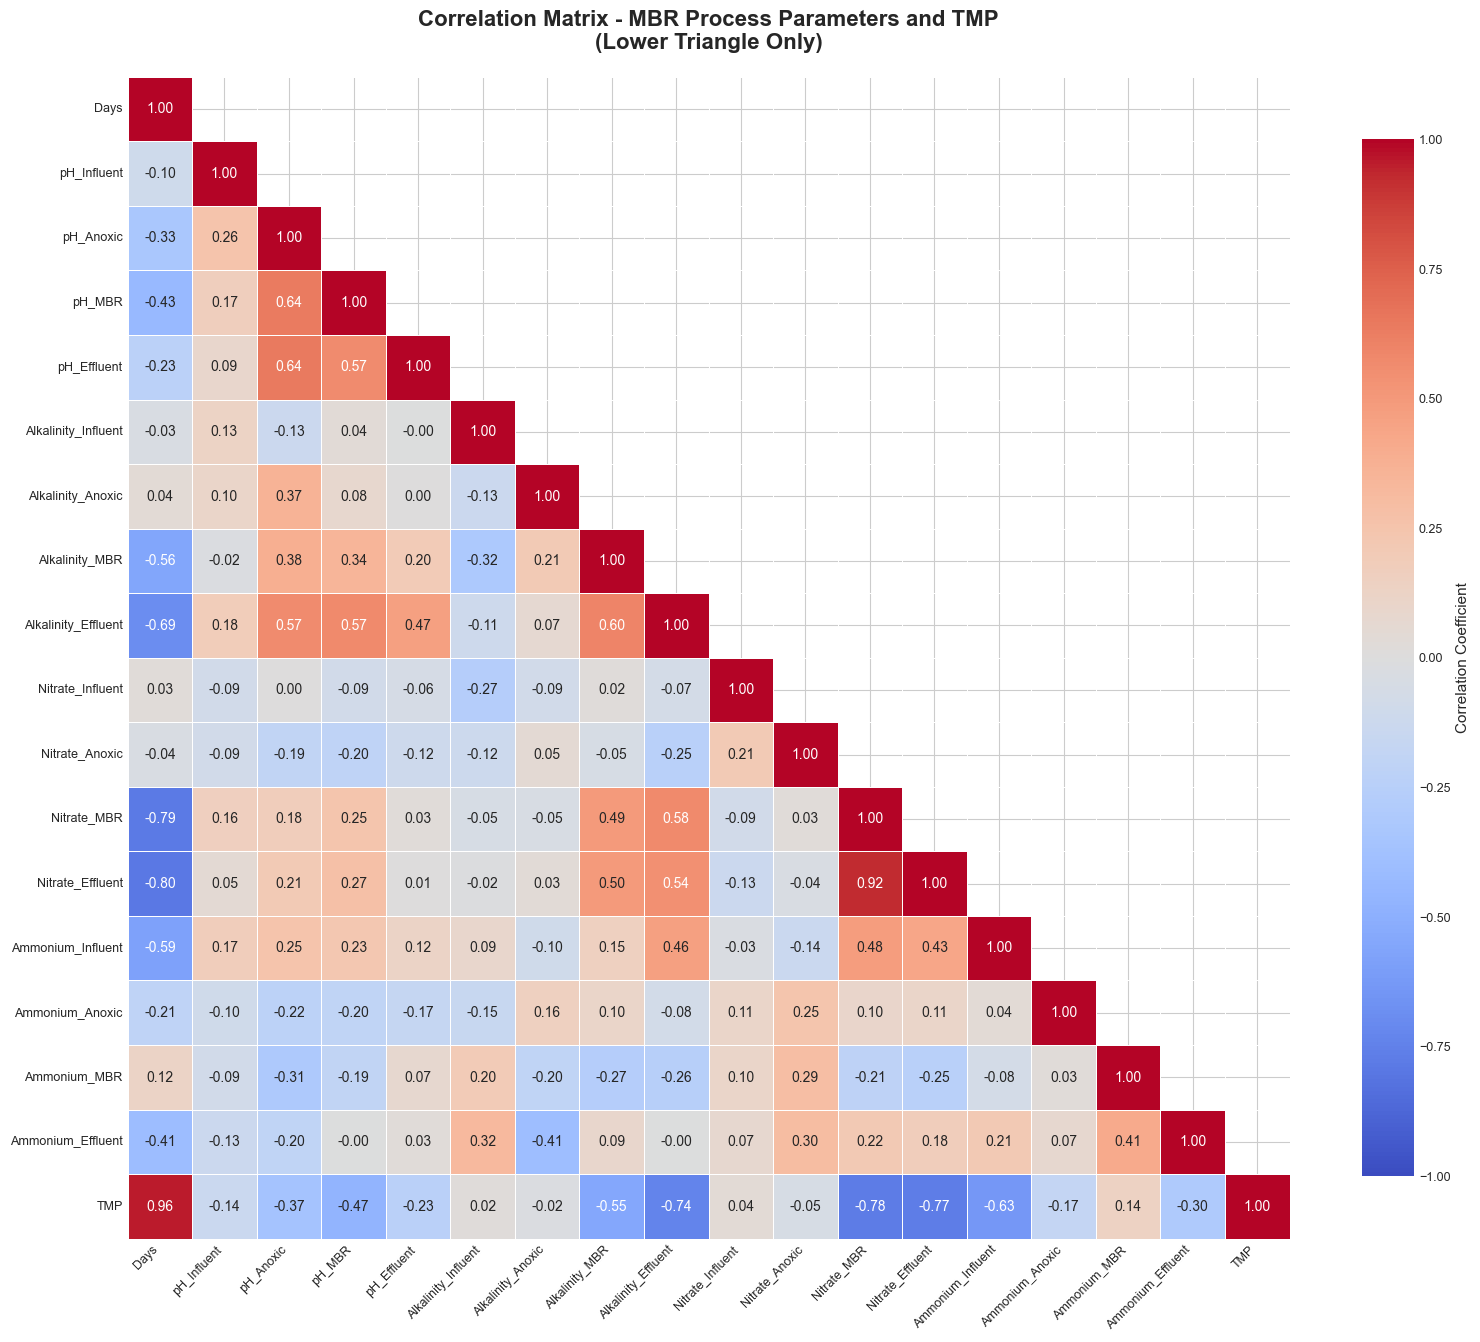

In [19]:
print("\n[1/12] Creating correlation heatmap...")

fig, ax = plt.subplots(figsize=(16, 14))

# Calculate correlation matrix
numeric_cols = df_plot.select_dtypes(include=[np.number]).columns
corr_matrix = df_plot[numeric_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Create heatmap with annotations
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            vmin=-1, vmax=1,
            ax=ax)

plt.title('Correlation Matrix - MBR Process Parameters and TMP\n(Lower Triangle Only)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('01_correlation_heatmap.png', bbox_inches='tight')
plt.show()

### FIGURE 2: TMP CORRELATION BAR PLOT

[2/12] Creating TMP correlation bar plot...


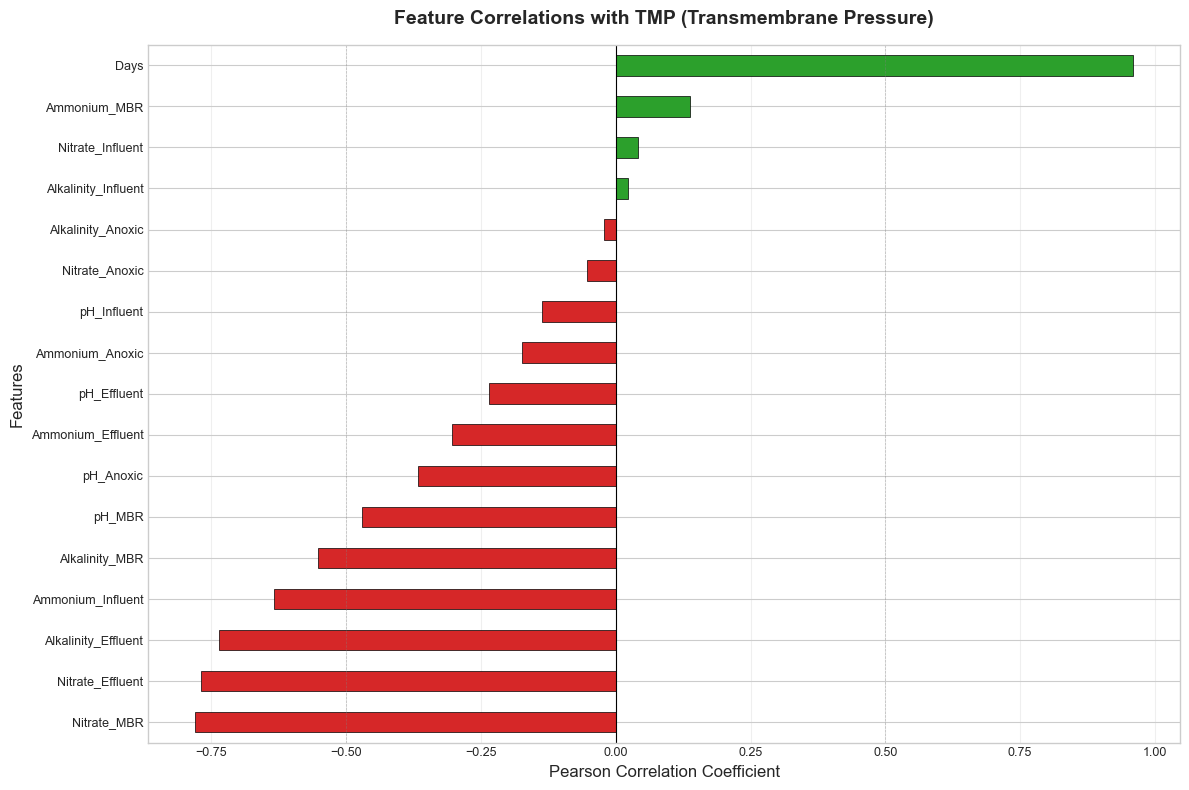

In [20]:
print("[2/12] Creating TMP correlation bar plot...")

fig, ax = plt.subplots(figsize=(12, 8))

# Calculate correlations with TMP
tmp_corr = corr_matrix['TMP'].drop('TMP').sort_values()

# Color based on positive/negative
colors = ['#d62728' if x < 0 else '#2ca02c' for x in tmp_corr.values]

tmp_corr.plot(kind='barh', color=colors, ax=ax, edgecolor='black', linewidth=0.5)

plt.title('Feature Correlations with TMP (Transmembrane Pressure)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(x=-0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('02_tmp_correlation_barplot.png', bbox_inches='tight')
plt.show()

### FIGURE 3: TMP EVOLUTION OVER TIME

[3/12] Creating TMP temporal evolution plot...


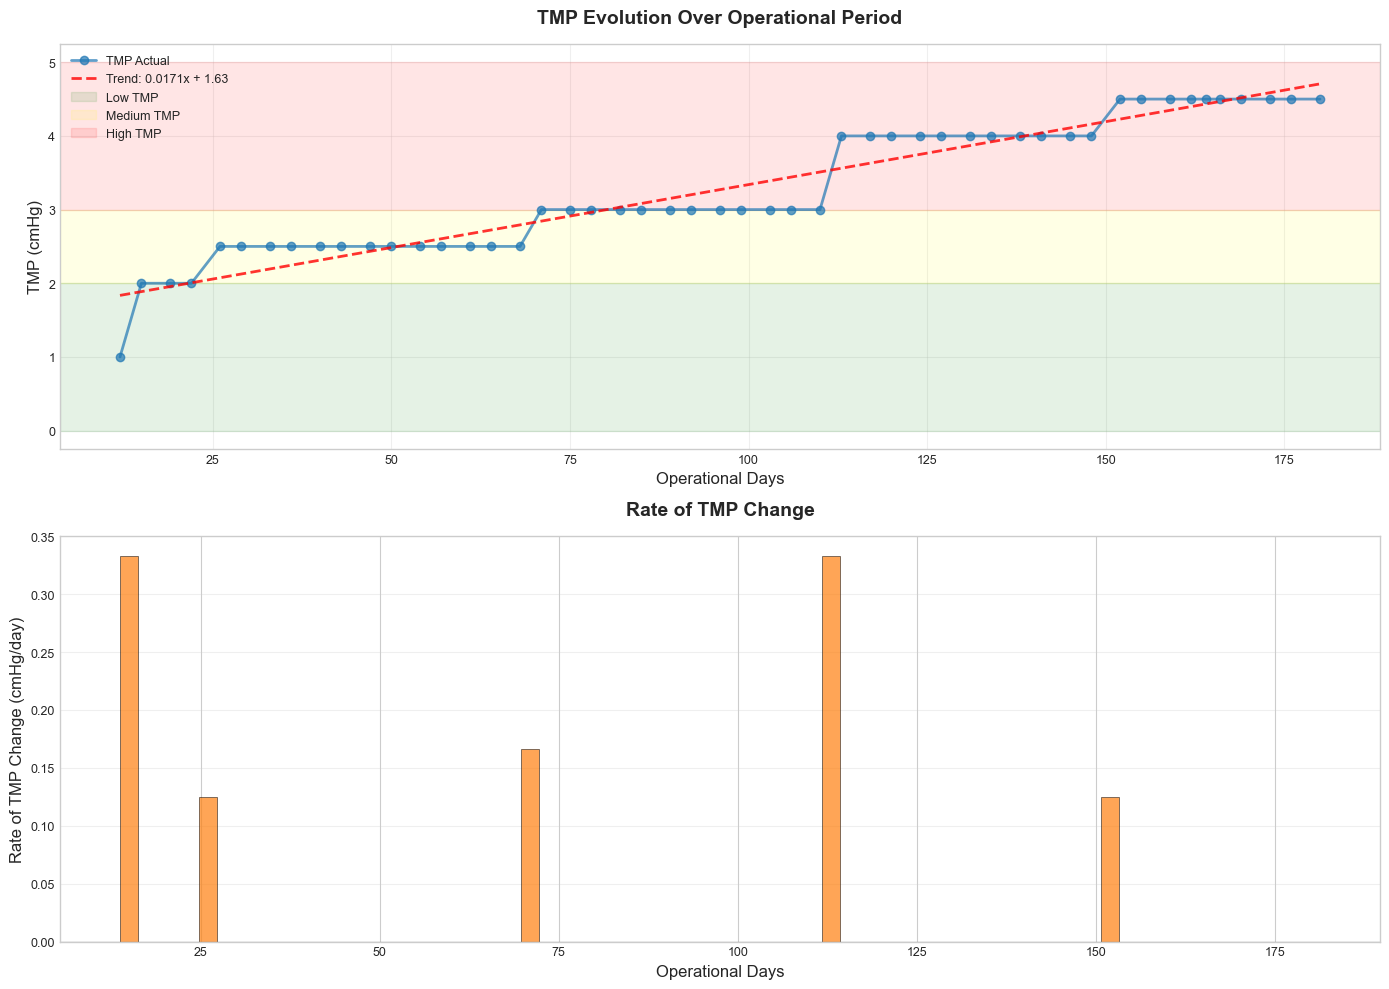

In [21]:
print("[3/12] Creating TMP temporal evolution plot...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: TMP over time with trend line
ax1.plot(df_plot['Days'], df_plot['TMP'], 
         marker='o', markersize=6, linewidth=2, 
         color='#1f77b4', label='TMP Actual', alpha=0.7)

# Add trend line
z = np.polyfit(df_plot['Days'], df_plot['TMP'], 1)
p = np.poly1d(z)
ax1.plot(df_plot['Days'], p(df_plot['Days']), 
         linestyle='--', linewidth=2, color='red', 
         label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}', alpha=0.8)

# Add shaded regions for TMP levels
ax1.axhspan(0, 2, alpha=0.1, color='green', label='Low TMP')
ax1.axhspan(2, 3, alpha=0.1, color='yellow', label='Medium TMP')
ax1.axhspan(3, 5, alpha=0.1, color='red', label='High TMP')

ax1.set_xlabel('Operational Days', fontsize=12)
ax1.set_ylabel('TMP (cmHg)', fontsize=12)
ax1.set_title('TMP Evolution Over Operational Period', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Rate of change
tmp_diff = df_plot['TMP'].diff()
days_diff = df_plot['Days'].diff()
rate_of_change = tmp_diff / days_diff

ax2.bar(df_plot['Days'][1:], rate_of_change[1:], 
        width=2.5, color='#ff7f0e', edgecolor='black', linewidth=0.5, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Operational Days', fontsize=12)
ax2.set_ylabel('Rate of TMP Change (cmHg/day)', fontsize=12)
ax2.set_title('Rate of TMP Change', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('03_tmp_temporal_evolution.png', bbox_inches='tight')
plt.show()

### FIGURE 4: DISTRIBUTION PLOTS FOR ALL FEATURES

[4/12] Creating distribution plots...


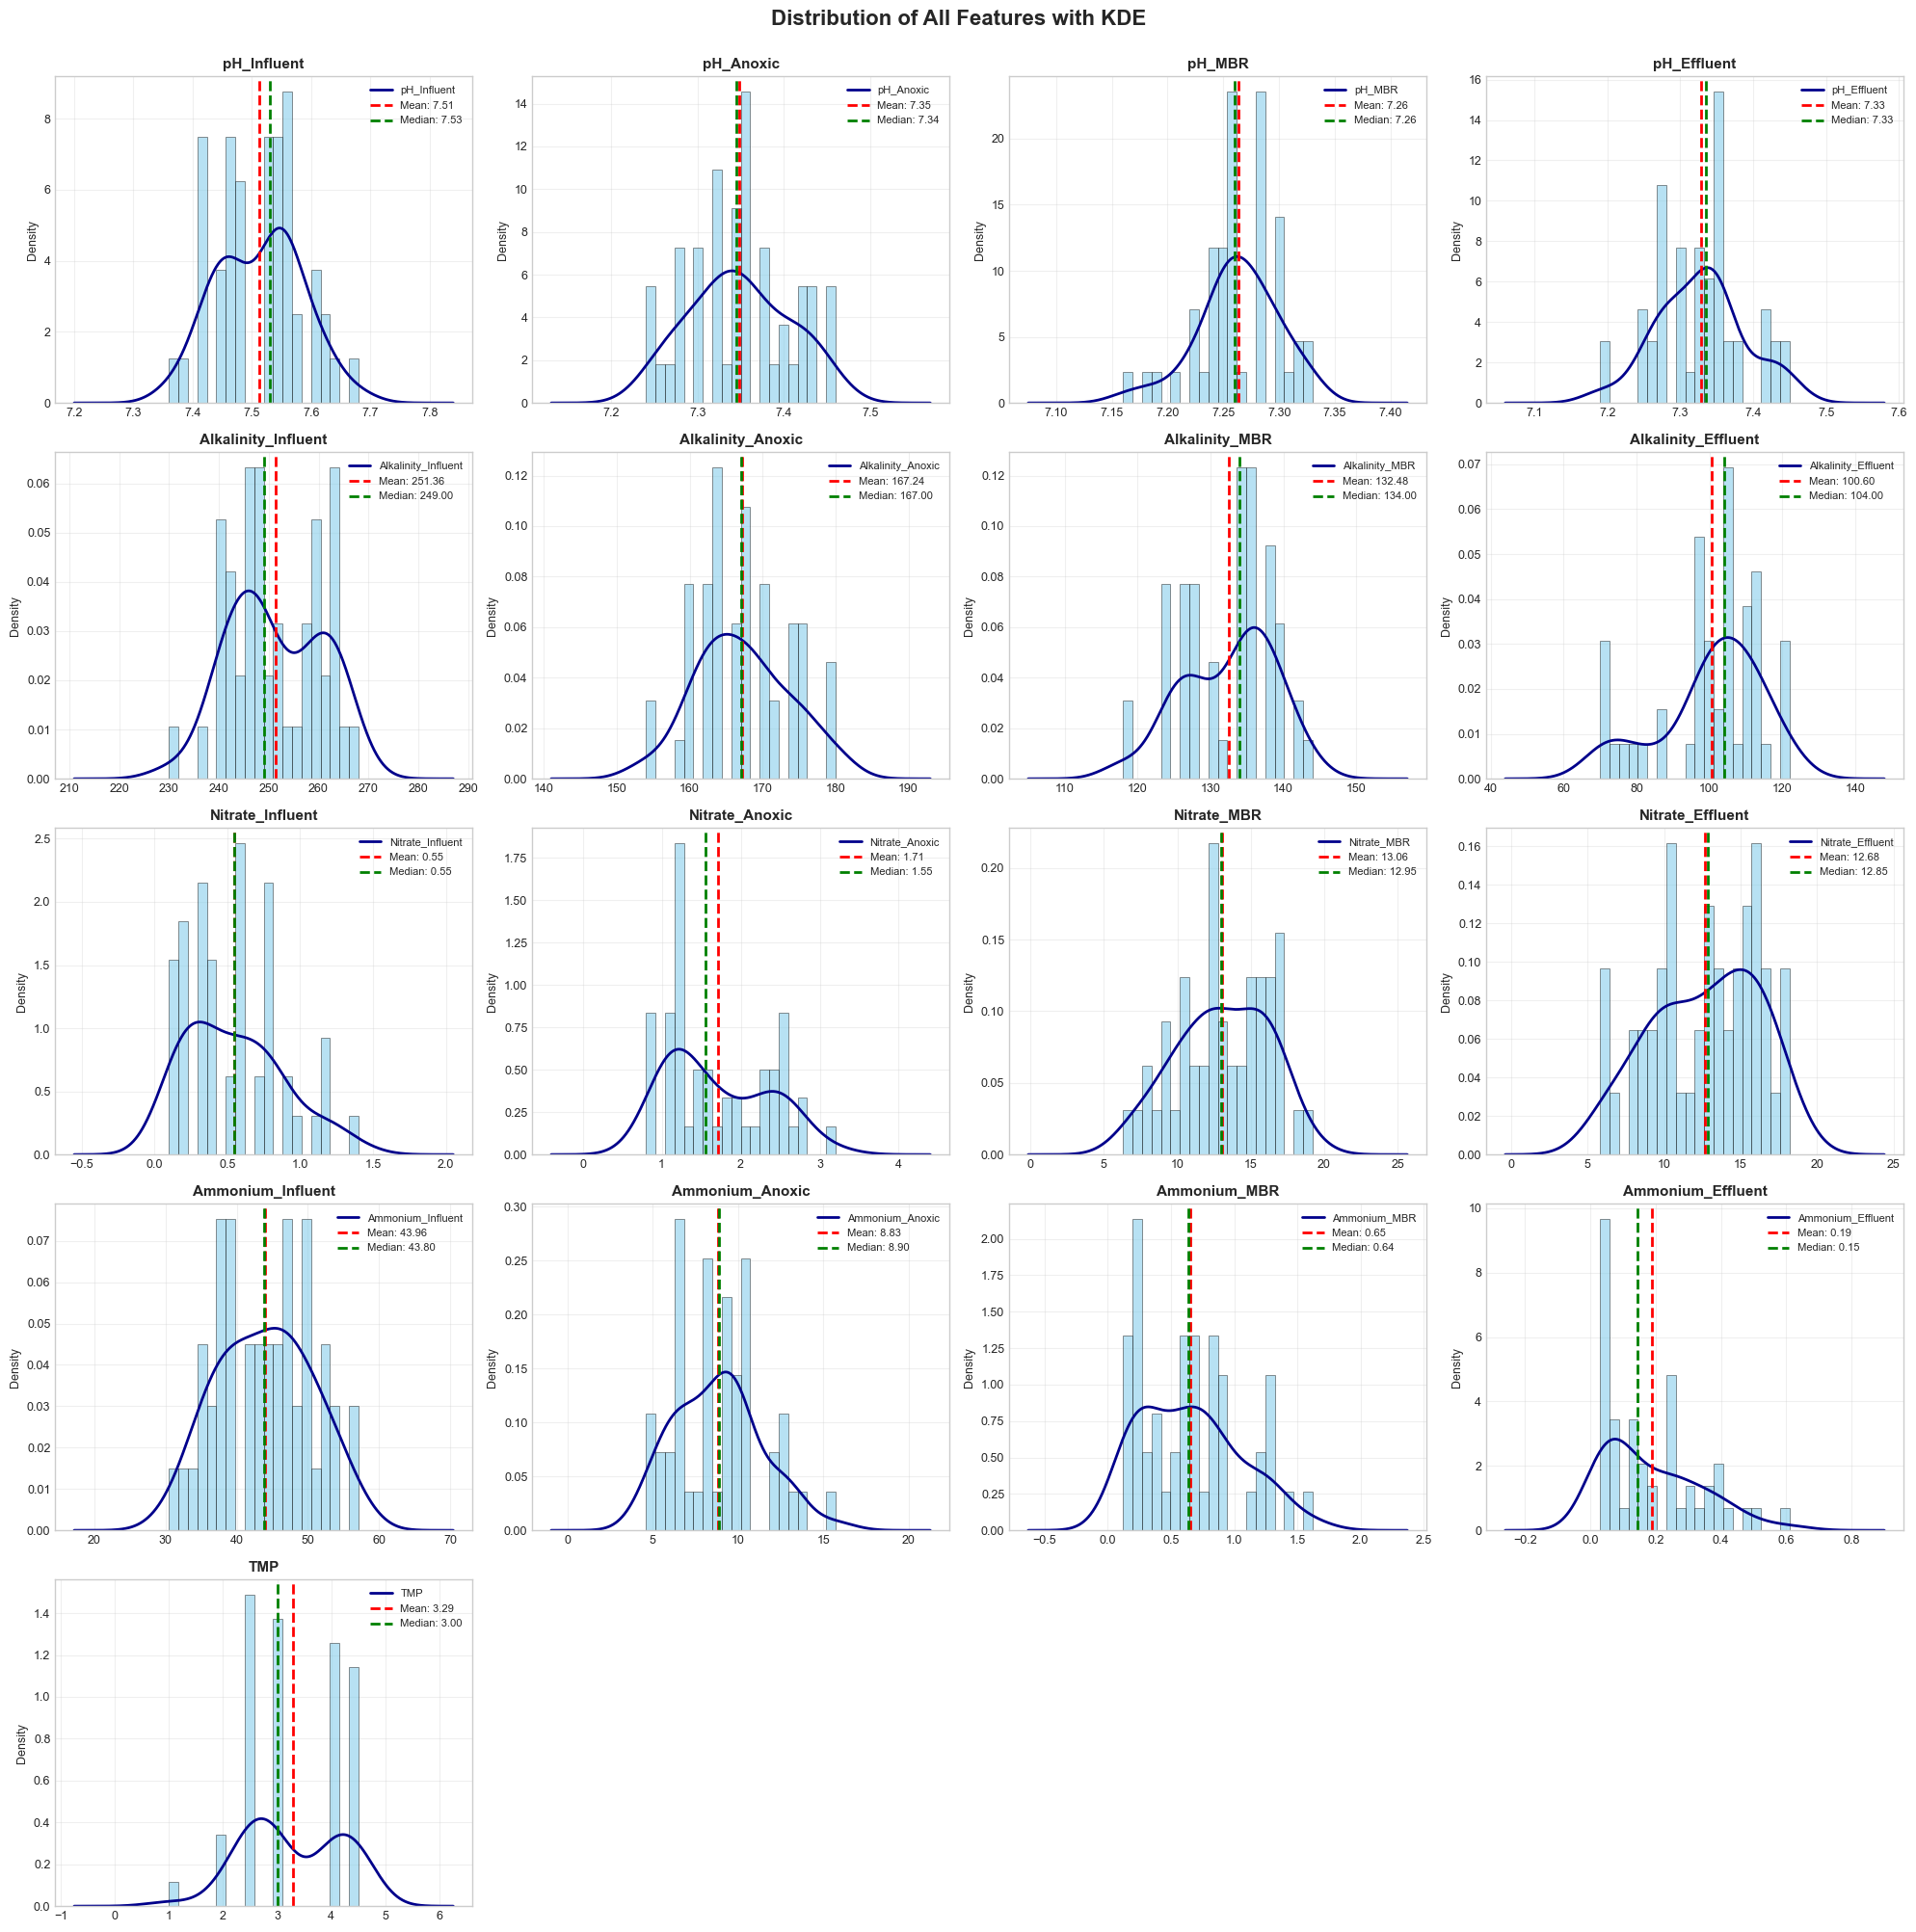

In [22]:
print("[4/12] Creating distribution plots...")

# Select numeric columns excluding Days
feature_cols = [col for col in numeric_cols if col != 'Days']
n_cols = 4
n_rows = int(np.ceil(len(feature_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    
    # Histogram with KDE
    ax.hist(df_plot[col], bins=20, alpha=0.6, color='skyblue', 
            edgecolor='black', linewidth=0.5, density=True)
    
    # KDE overlay
    df_plot[col].plot(kind='kde', ax=ax, color='darkblue', linewidth=2)
    
    # Add mean and median lines
    mean_val = df_plot[col].mean()
    median_val = df_plot[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of All Features with KDE', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('04_feature_distributions.png', bbox_inches='tight')
plt.show()

### FIGURE 5: BOX PLOTS FOR OUTLIER DETECTION

[5/12] Creating box plots for outlier detection...


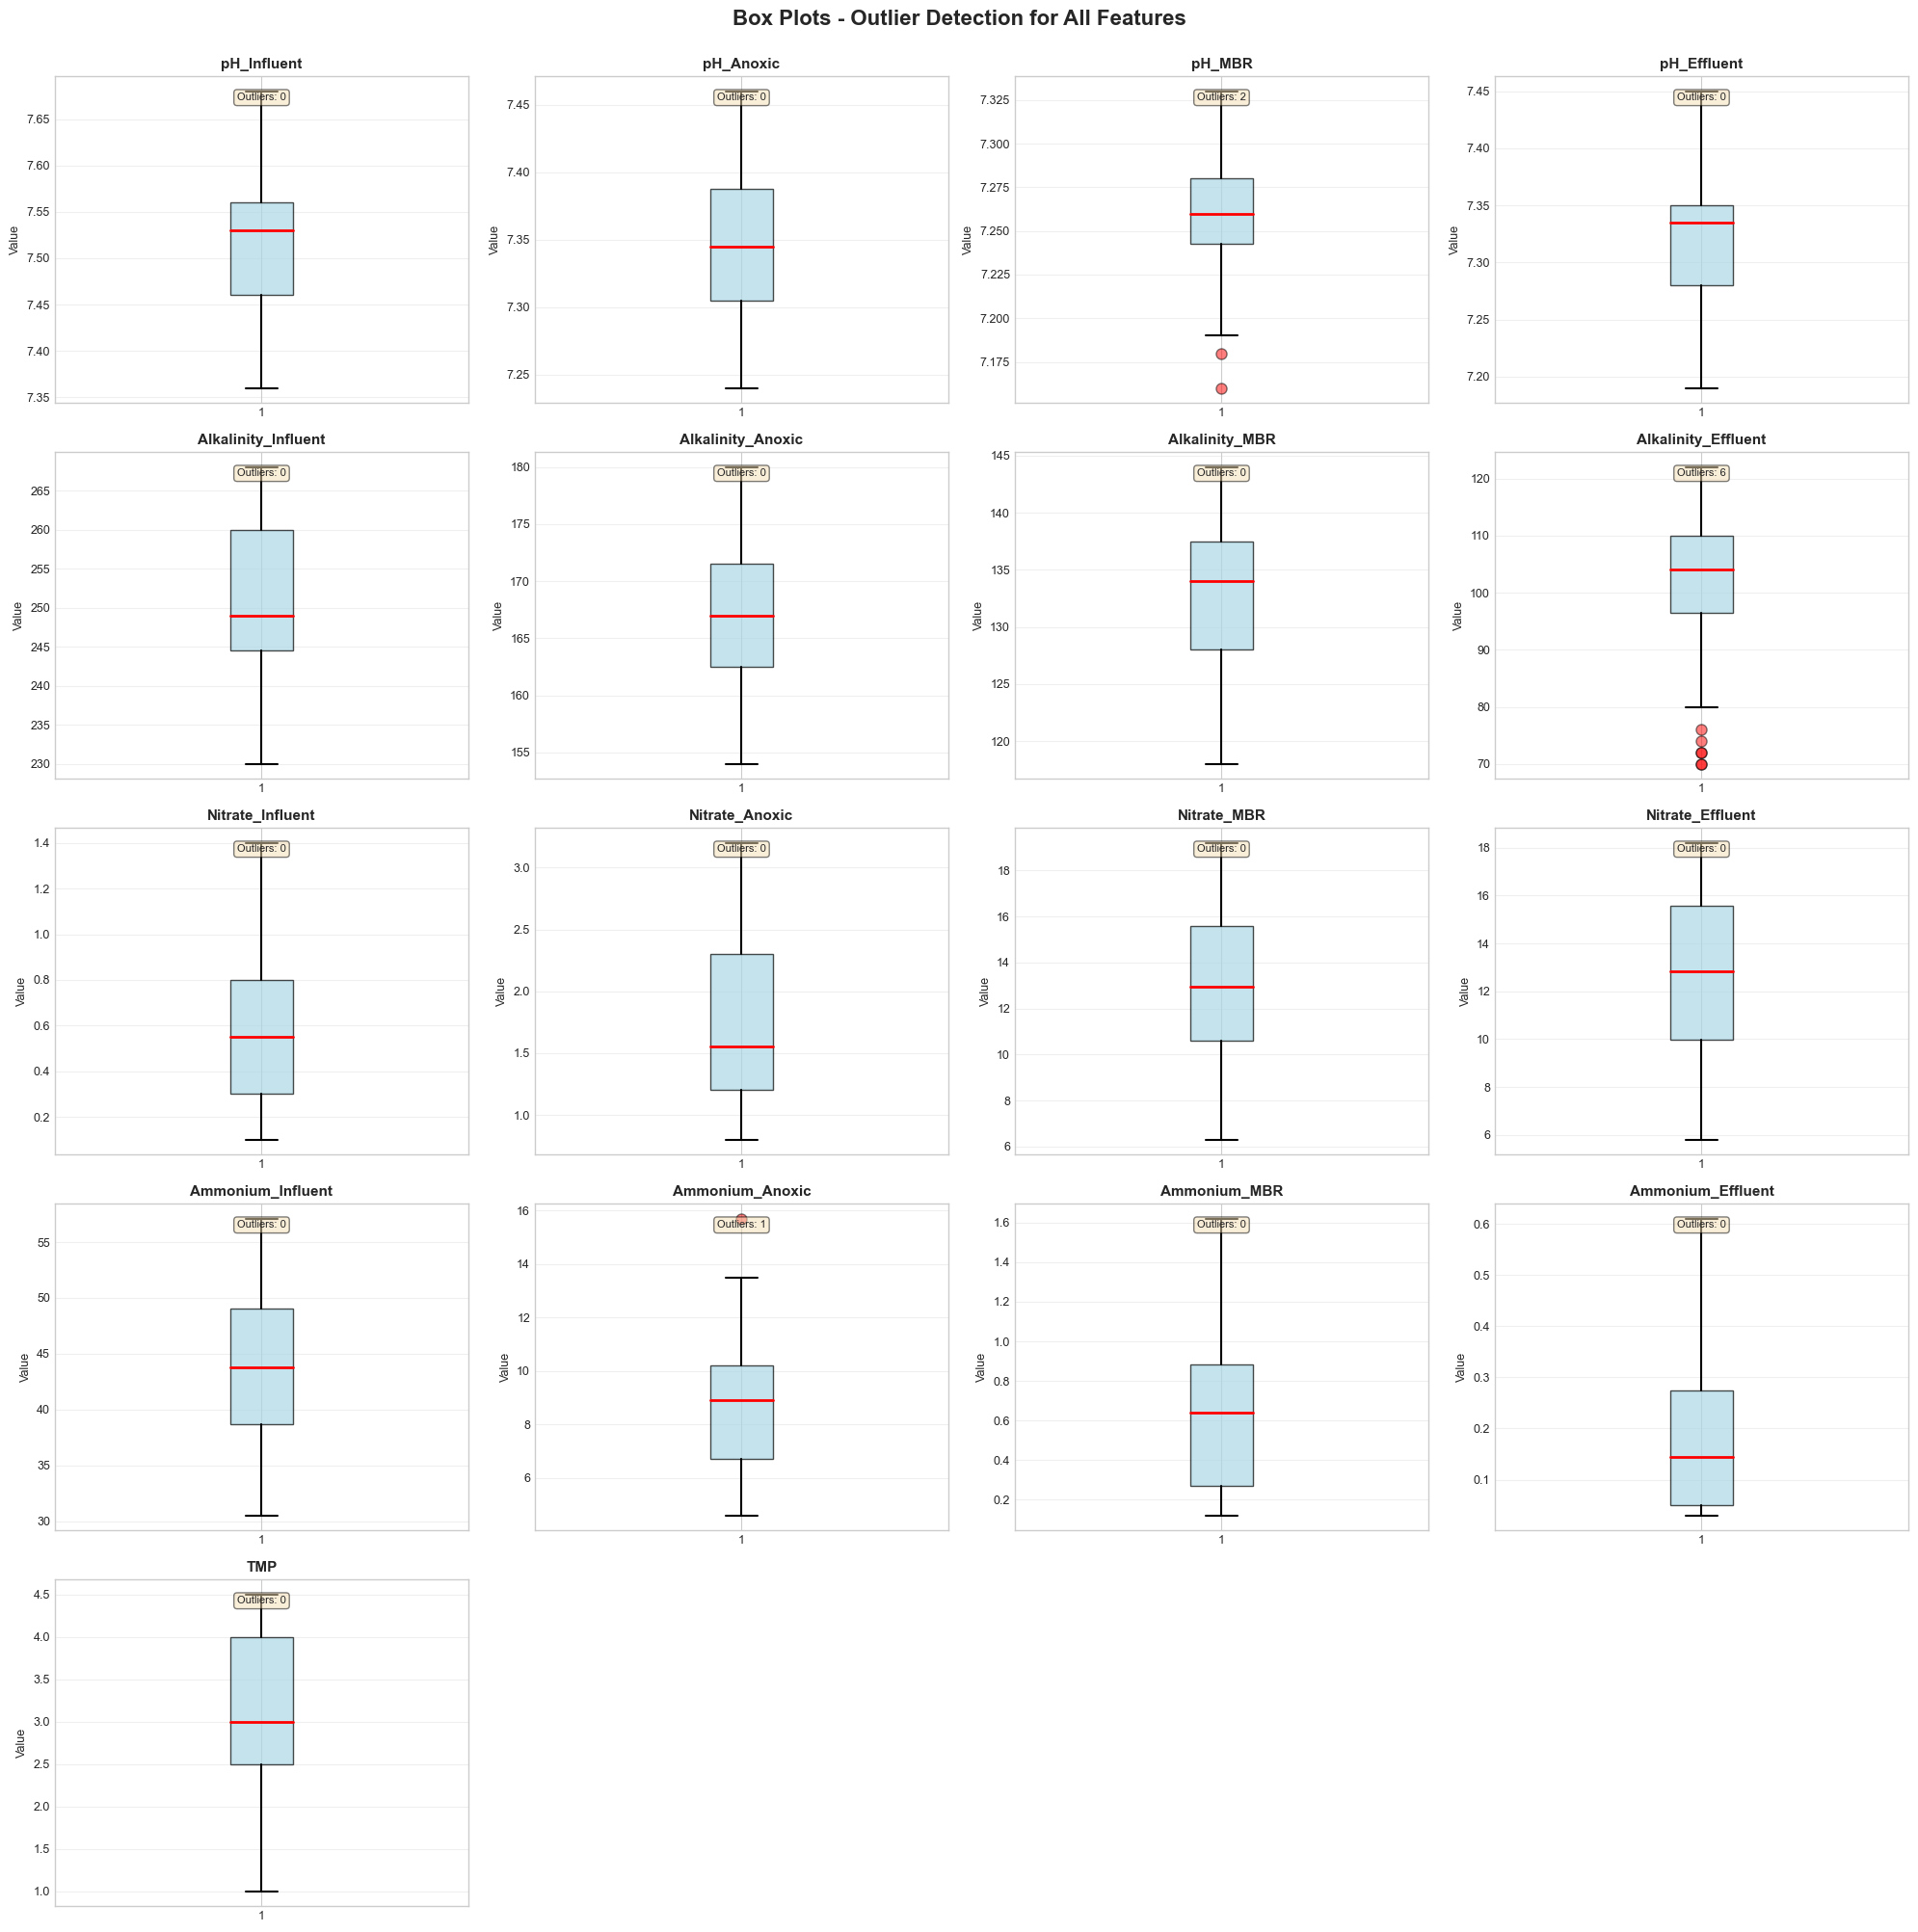

In [23]:
print("[5/12] Creating box plots for outlier detection...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    
    bp = ax.boxplot(df_plot[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', 
                                   markersize=8, alpha=0.5))
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    q1 = df_plot[col].quantile(0.25)
    q3 = df_plot[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_plot[(df_plot[col] < q1 - 1.5*iqr) | (df_plot[col] > q3 + 1.5*iqr)][col]
    
    ax.text(0.5, 0.95, f'Outliers: {len(outliers)}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=8)

# Hide empty subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Box Plots - Outlier Detection for All Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('05_boxplots_outliers.png', bbox_inches='tight')
plt.show()

### FIGURE 6: SCATTER PLOTS - TOP CORRELATIONS WITH TMP


[6/12] Creating scatter plots for top correlations...


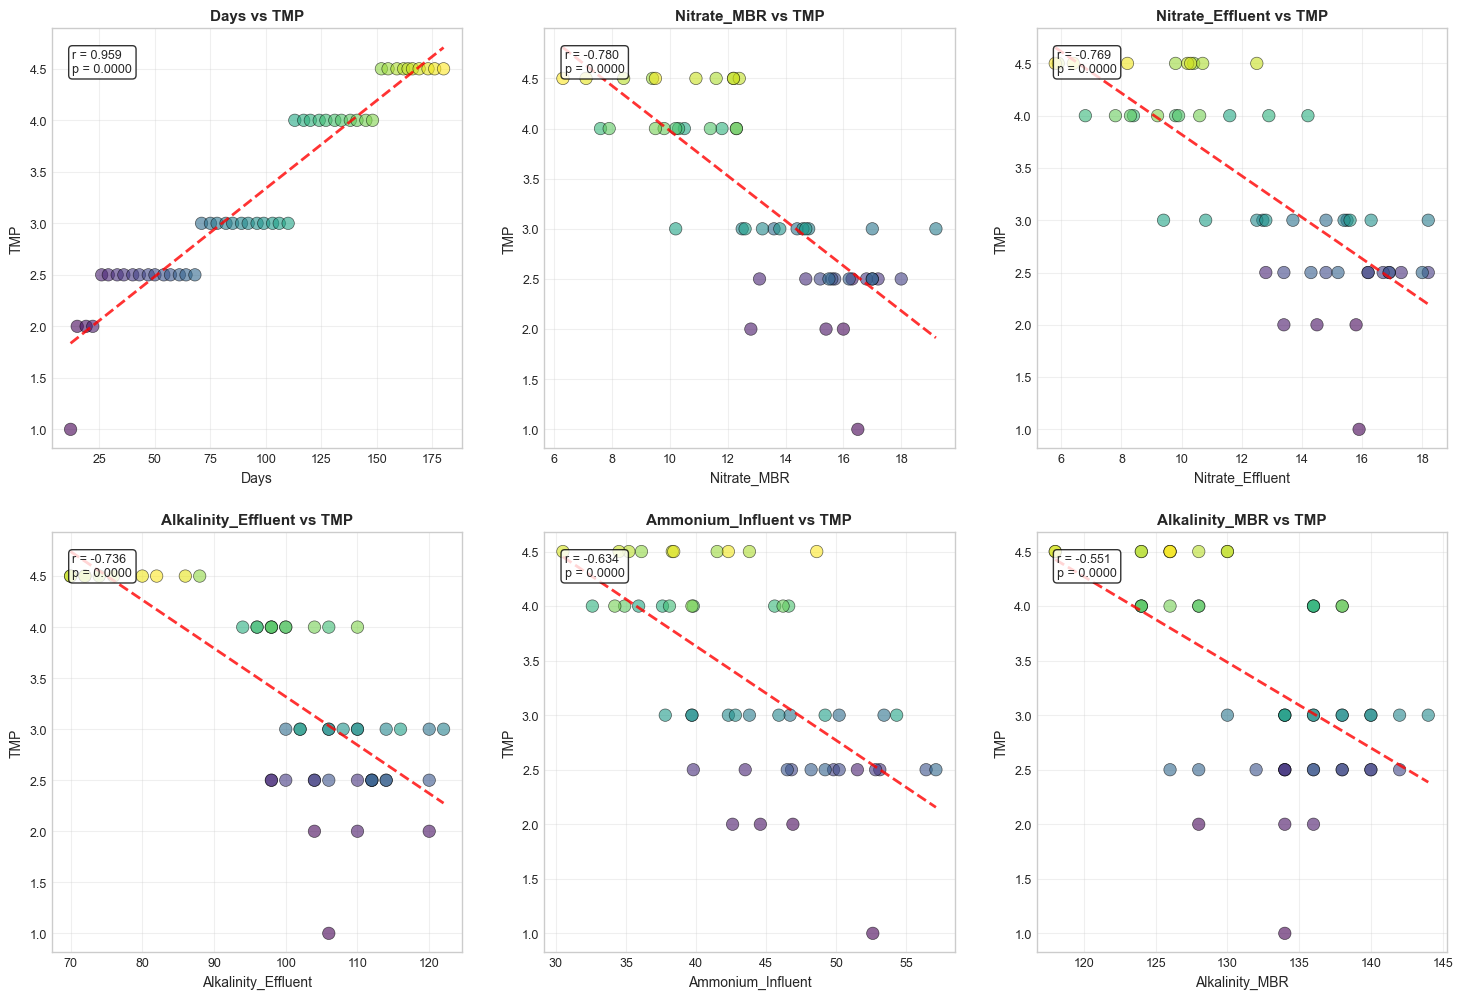

In [26]:
print("[6/12] Creating scatter plots for top correlations...")

# Get top 6 correlations
top_features = corr_matrix['TMP'].drop('TMP').abs().sort_values(ascending=False).head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df_plot[feature], df_plot['TMP'], 
              alpha=0.6, s=80, c=df_plot['Days'], cmap='viridis', 
              edgecolors='black', linewidth=0.5)
    
    # Add regression line
    z = np.polyfit(df_plot[feature], df_plot['TMP'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_plot[feature].min(), df_plot[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)
    
    # Calculate and display correlation
    corr, p_val = pearsonr(df_plot[feature], df_plot['TMP'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}\np = {p_val:.4f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('TMP', fontsize=10)
    ax.set_title(f'{feature} vs TMP', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)



### FIGURE 7: PAIRPLOT FOR KEY FEATURES

[7/12] Creating pairplot for key features...


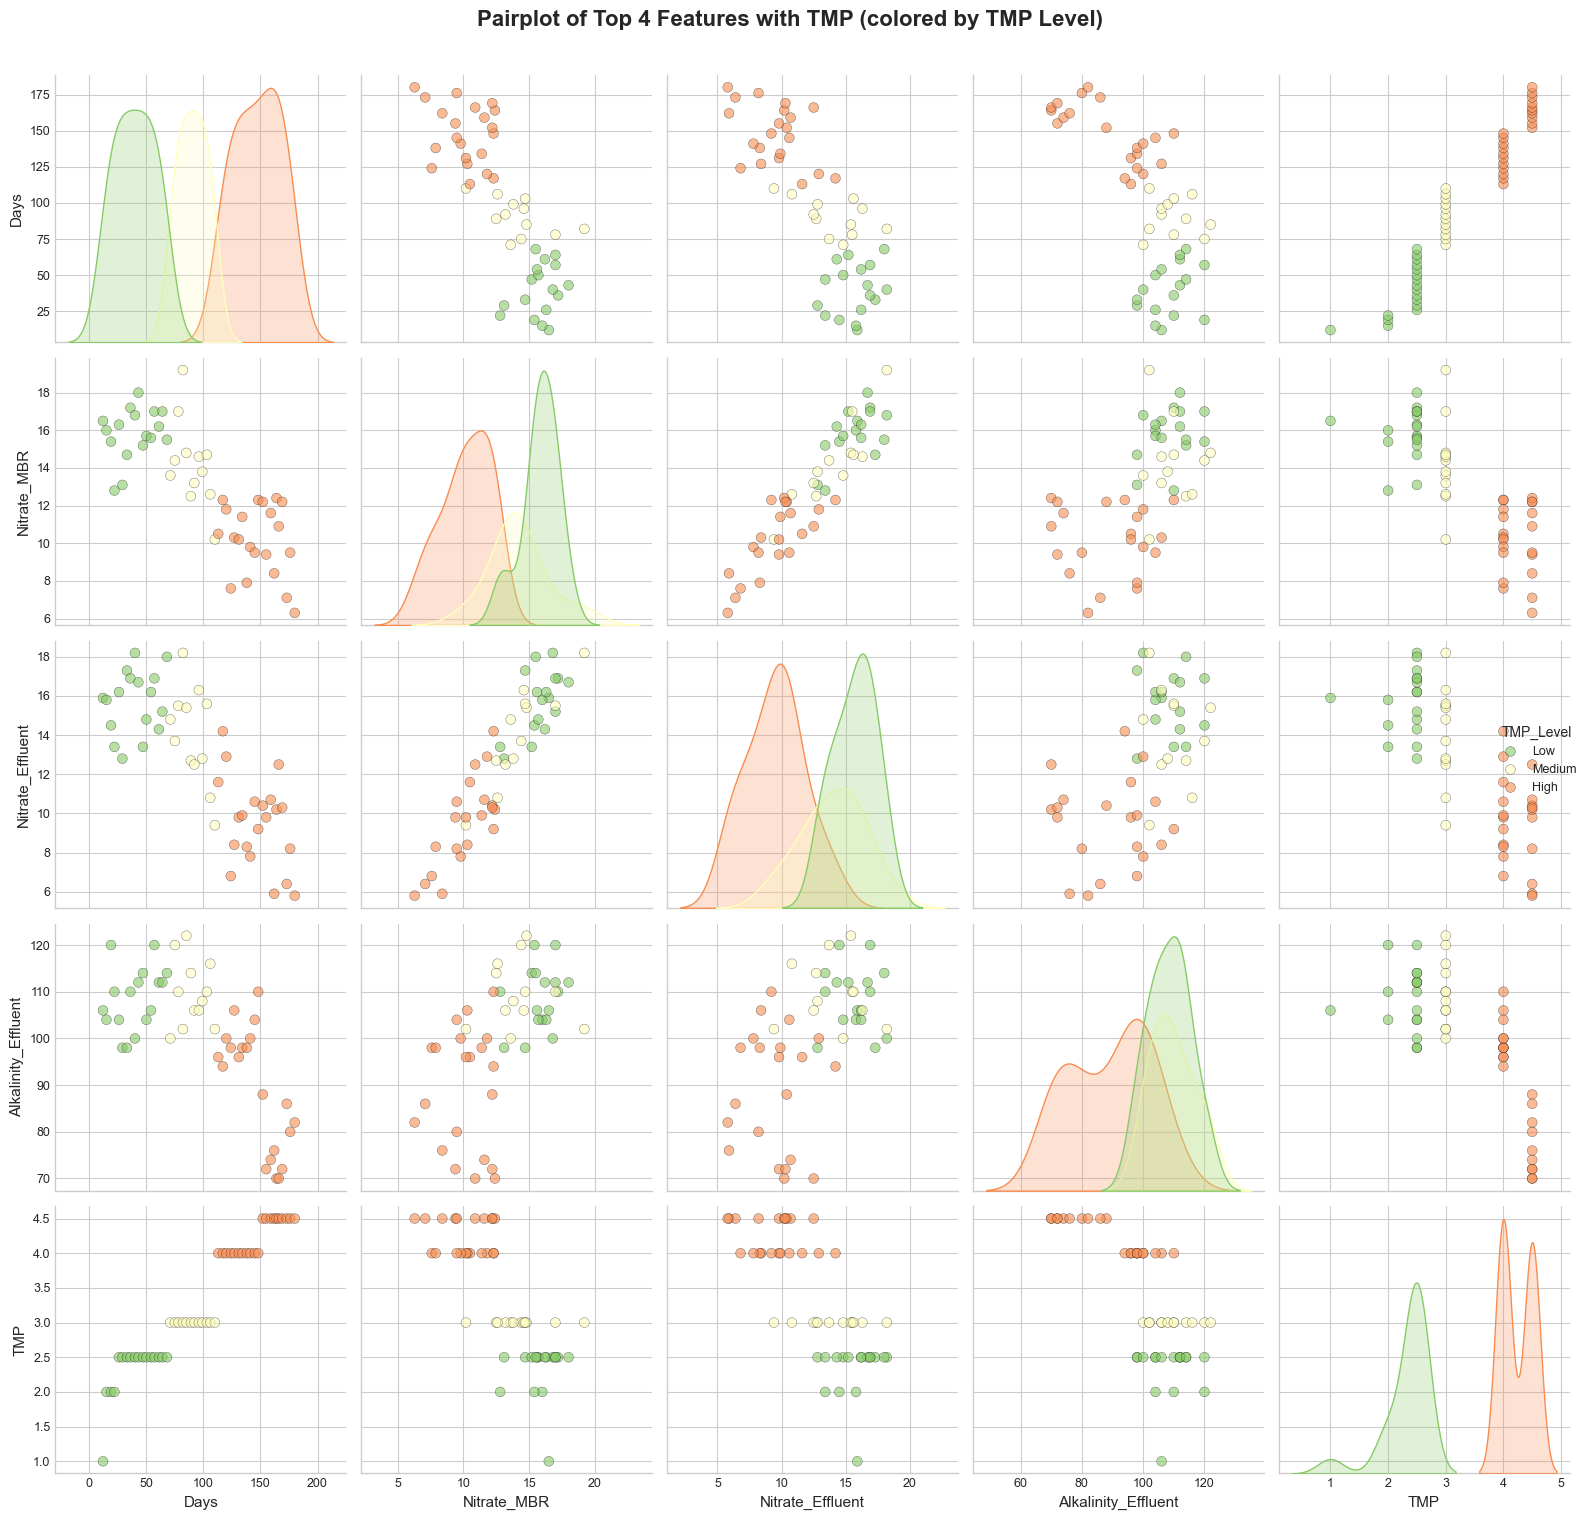

In [27]:
print("[7/12] Creating pairplot for key features...")

# Select key features based on correlation
key_features = list(top_features[:4]) + ['TMP']
df_subset = df_plot[key_features].copy()

# Create TMP categories for coloring
df_subset['TMP_Level'] = pd.cut(df_plot['TMP'], 
                                 bins=[0, 2.5, 3.5, 5], 
                                 labels=['Low', 'Medium', 'High'])

# Create pairplot
g = sns.pairplot(df_subset, hue='TMP_Level', palette='RdYlGn_r', 
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'black', 'linewidth': 0.3},
                 height=3)
g.fig.suptitle('Pairplot of Top 4 Features with TMP (colored by TMP Level)', 
               fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('07_pairplot_key_features.png', bbox_inches='tight')
plt.show()

### FIGURE 8: TEMPORAL EVOLUTION OF ALL PARAMETERS


[8/12] Creating temporal evolution plots...


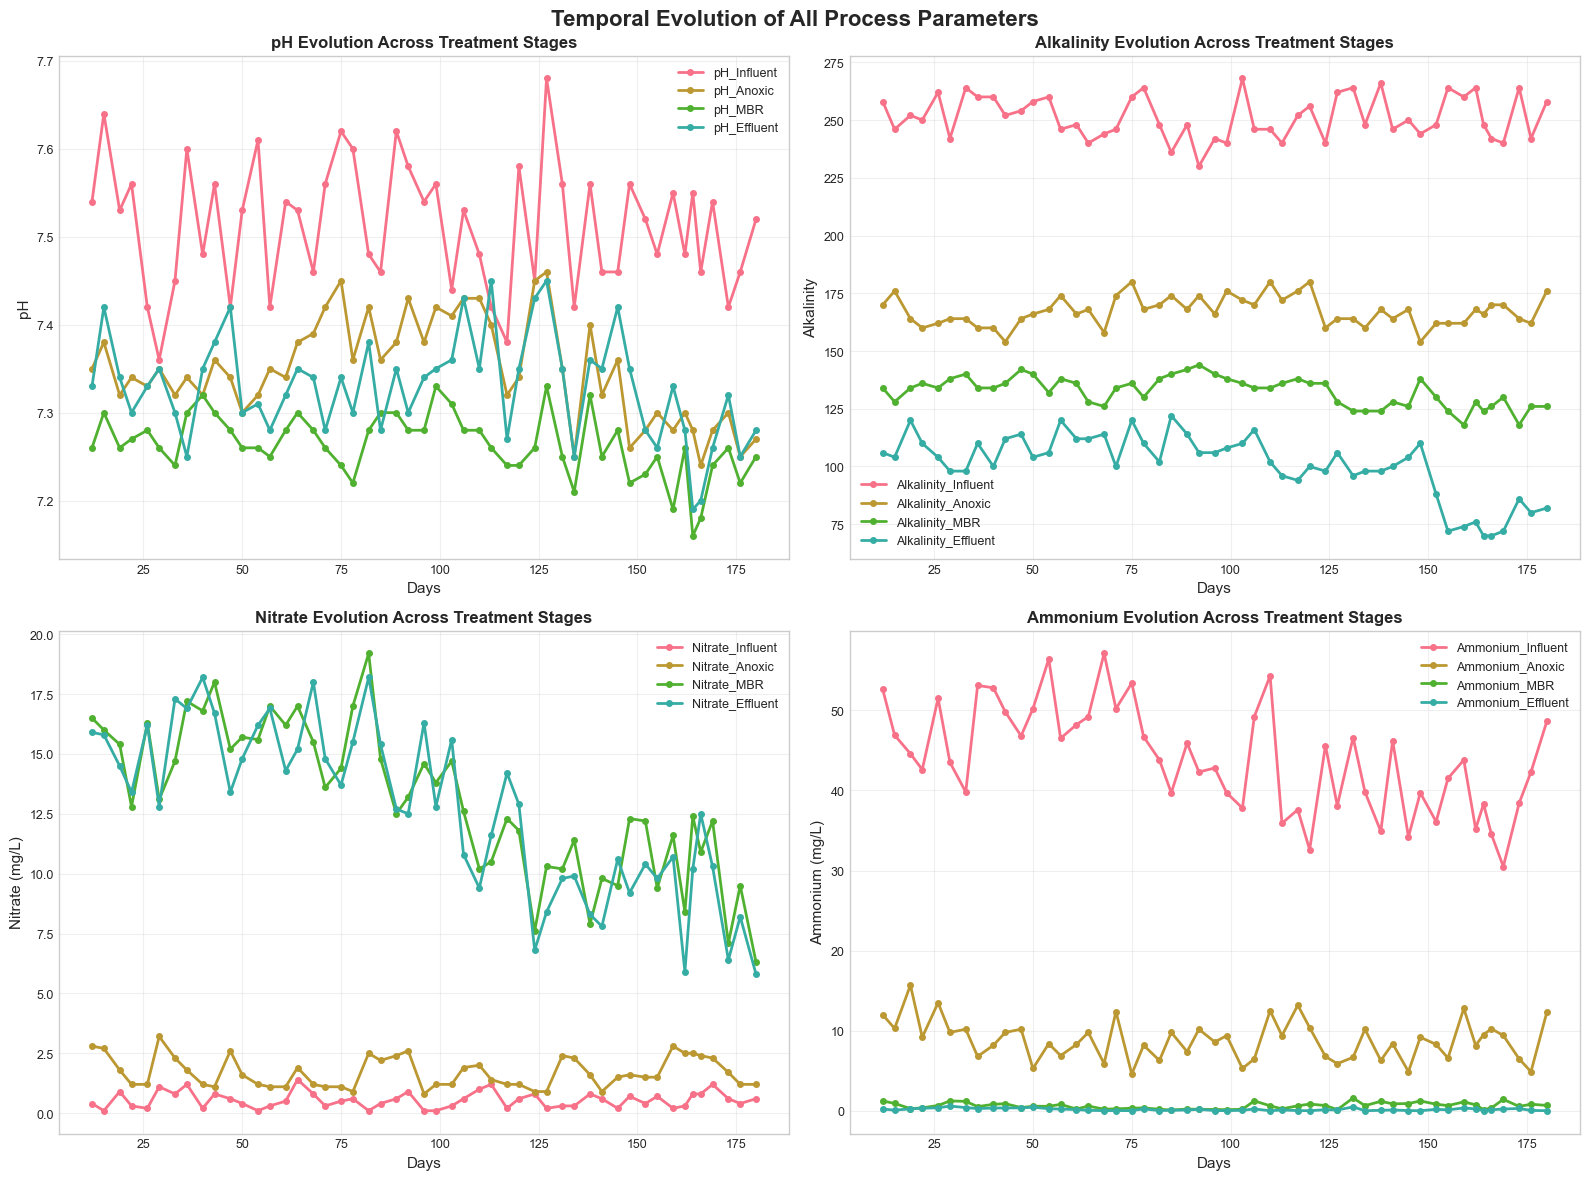

In [28]:
print("[8/12] Creating temporal evolution plots...")

# pH Parameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# pH over time
pH_cols = [col for col in df_plot.columns if 'pH' in col]
for col in pH_cols:
    axes[0, 0].plot(df_plot['Days'], df_plot[col], marker='o', 
                    label=col, linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Days', fontsize=11)
axes[0, 0].set_ylabel('pH', fontsize=11)
axes[0, 0].set_title('pH Evolution Across Treatment Stages', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Alkalinity over time
alk_cols = [col for col in df_plot.columns if 'Alkalinity' in col]
for col in alk_cols:
    axes[0, 1].plot(df_plot['Days'], df_plot[col], marker='o', 
                    label=col, linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Days', fontsize=11)
axes[0, 1].set_ylabel('Alkalinity', fontsize=11)
axes[0, 1].set_title('Alkalinity Evolution Across Treatment Stages', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Nitrate over time
nit_cols = [col for col in df_plot.columns if 'Nitrate' in col]
for col in nit_cols:
    axes[1, 0].plot(df_plot['Days'], df_plot[col], marker='o', 
                    label=col, linewidth=2, markersize=4)
axes[1, 0].set_xlabel('Days', fontsize=11)
axes[1, 0].set_ylabel('Nitrate (mg/L)', fontsize=11)
axes[1, 0].set_title('Nitrate Evolution Across Treatment Stages', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Ammonium over time
amm_cols = [col for col in df_plot.columns if 'Ammonium' in col]
for col in amm_cols:
    axes[1, 1].plot(df_plot['Days'], df_plot[col], marker='o', 
                    label=col, linewidth=2, markersize=4)
axes[1, 1].set_xlabel('Days', fontsize=11)
axes[1, 1].set_ylabel('Ammonium (mg/L)', fontsize=11)
axes[1, 1].set_title('Ammonium Evolution Across Treatment Stages', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Temporal Evolution of All Process Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('08_temporal_evolution_all.png', bbox_inches='tight')
plt.show()

### FIGURE 9: VIOLIN PLOTS FOR DISTRIBUTION BY TMP LEVEL


[9/12] Creating violin plots...


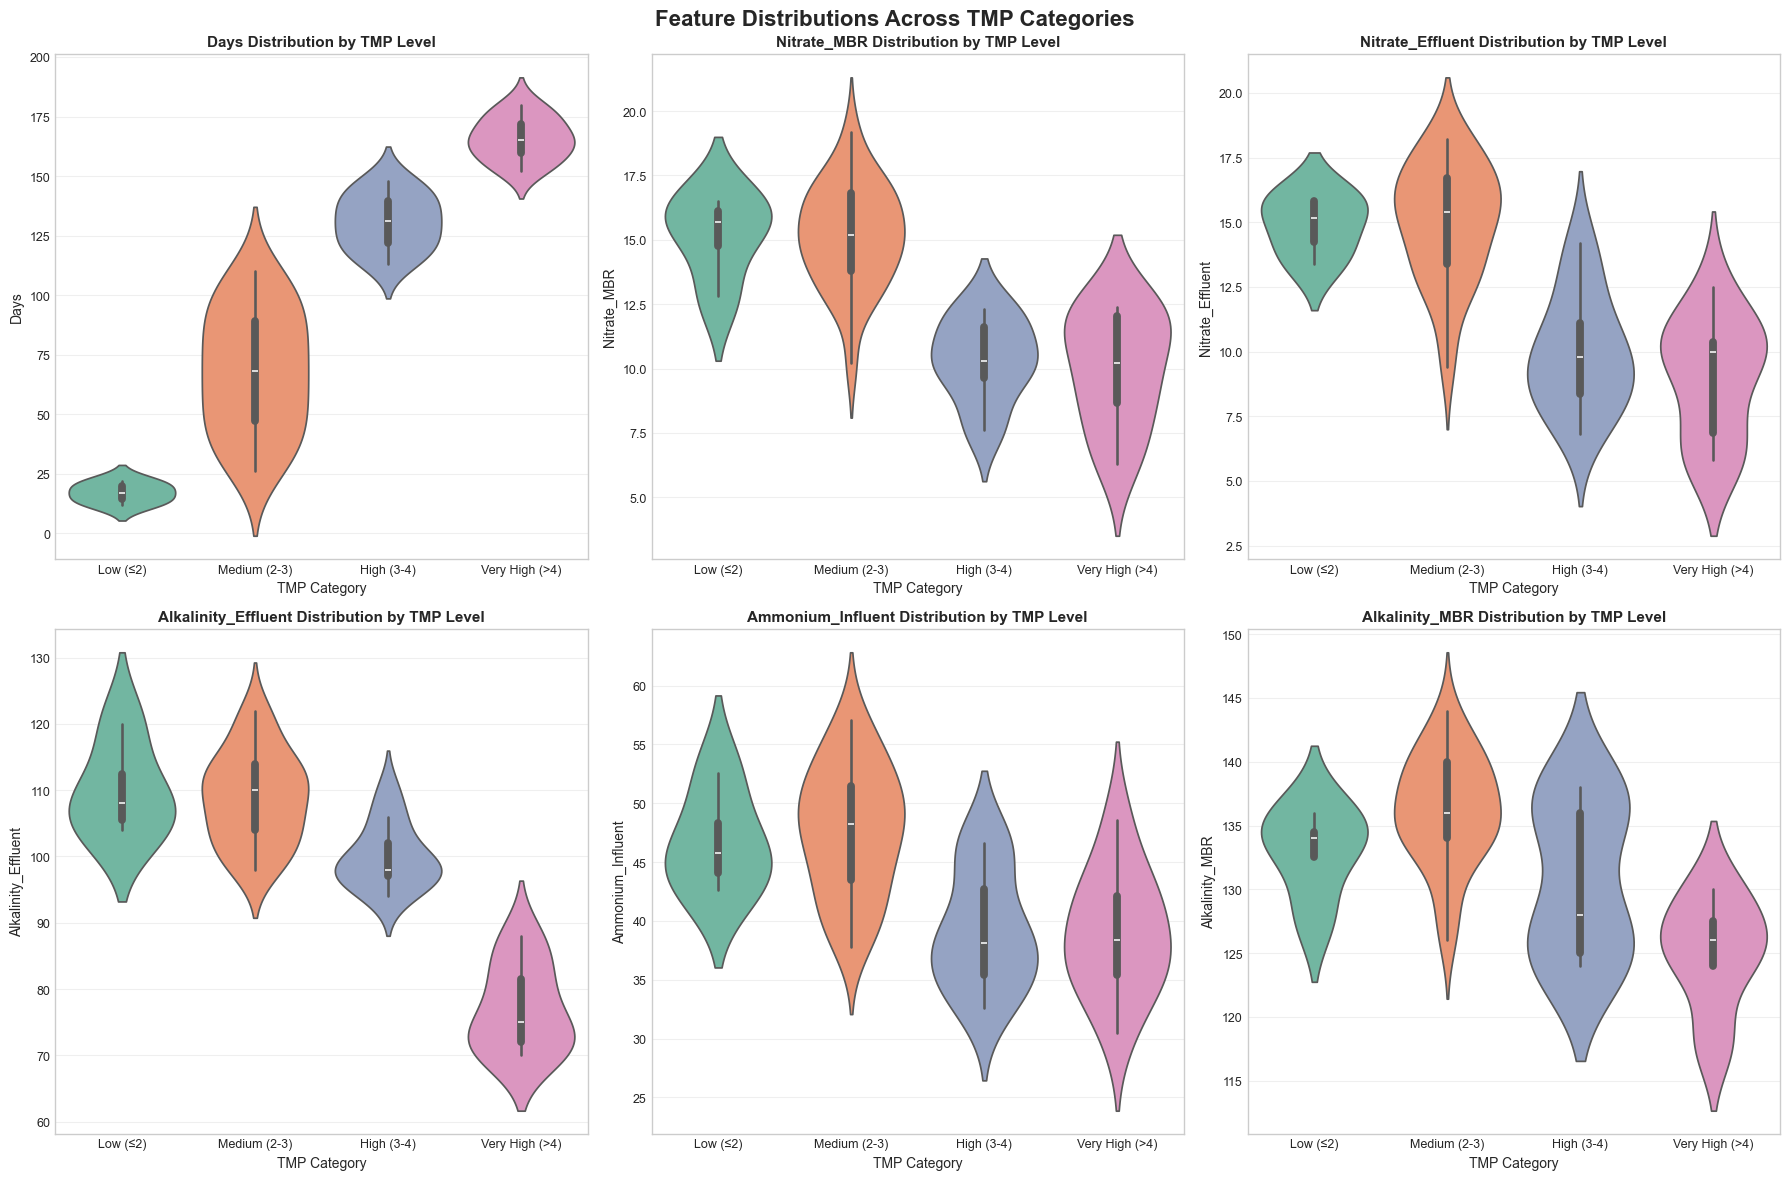

In [29]:
print("[9/12] Creating violin plots...")

# Create TMP categories
df_plot['TMP_Category'] = pd.cut(df_plot['TMP'], 
                                  bins=[0, 2, 3, 4, 5], 
                                  labels=['Low (≤2)', 'Medium (2-3)', 'High (3-4)', 'Very High (>4)'])

# Select top 6 features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    sns.violinplot(data=df_plot, x='TMP_Category', y=feature, 
                   ax=ax, palette='Set2', inner='box')
    
    ax.set_xlabel('TMP Category', fontsize=10)
    ax.set_ylabel(feature, fontsize=10)
    ax.set_title(f'{feature} Distribution by TMP Level', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Feature Distributions Across TMP Categories', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('09_violin_plots_tmp_categories.png', bbox_inches='tight')
plt.show()

### FIGURE 10: HEATMAP OF FEATURES OVER TIME


[10/12] Creating temporal heatmap...


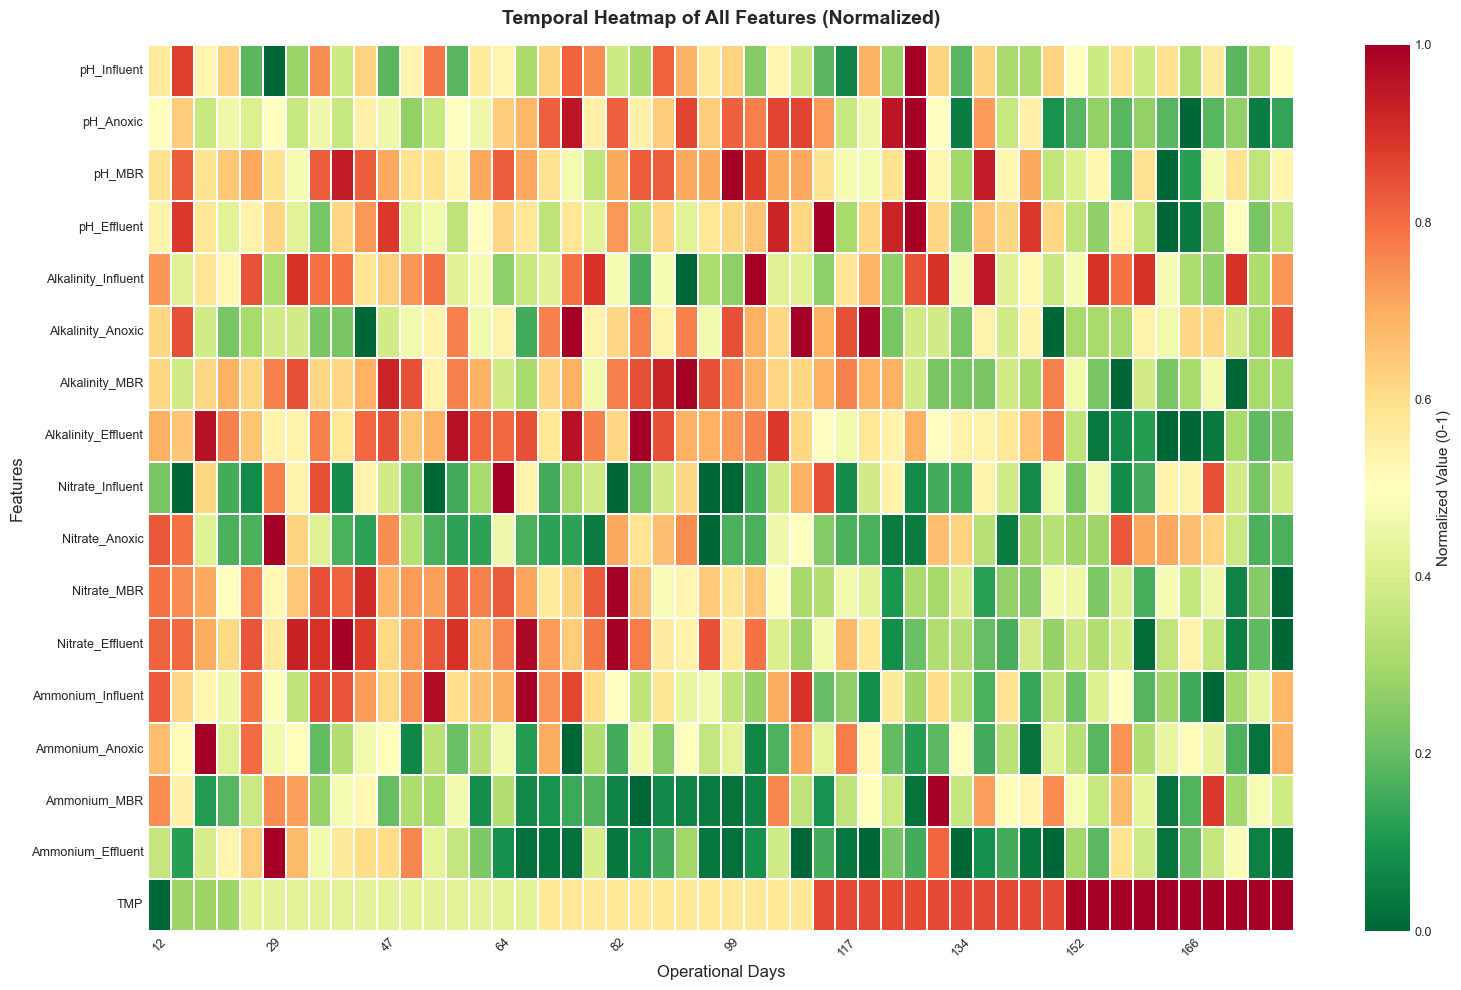

In [30]:
print("[10/12] Creating temporal heatmap...")

fig, ax = plt.subplots(figsize=(16, 10))

# Normalize features for better visualization
df_normalized = df_plot[feature_cols].copy()
for col in df_normalized.columns:
    df_normalized[col] = (df_normalized[col] - df_normalized[col].min()) / \
                          (df_normalized[col].max() - df_normalized[col].min())

# Transpose for time on x-axis
sns.heatmap(df_normalized.T, cmap='RdYlGn_r', cbar_kws={'label': 'Normalized Value (0-1)'},
            xticklabels=df_plot['Days'].astype(int), yticklabels=df_normalized.columns,
            ax=ax, linewidths=0.1)

ax.set_xlabel('Operational Days', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Temporal Heatmap of All Features (Normalized)', fontsize=14, fontweight='bold', pad=15)

# Show every 5th day label
xticks = ax.get_xticks()
ax.set_xticks(xticks[::5])
ax.set_xticklabels([df_plot['Days'].iloc[int(i)] if i < len(df_plot) else '' 
                     for i in xticks[::5]], rotation=45)

plt.tight_layout()
plt.savefig('10_temporal_heatmap.png', bbox_inches='tight')
plt.show()

### FIGURE 11: Q-Q PLOTS FOR NORMALITY CHECK

[11/12] Creating Q-Q plots...


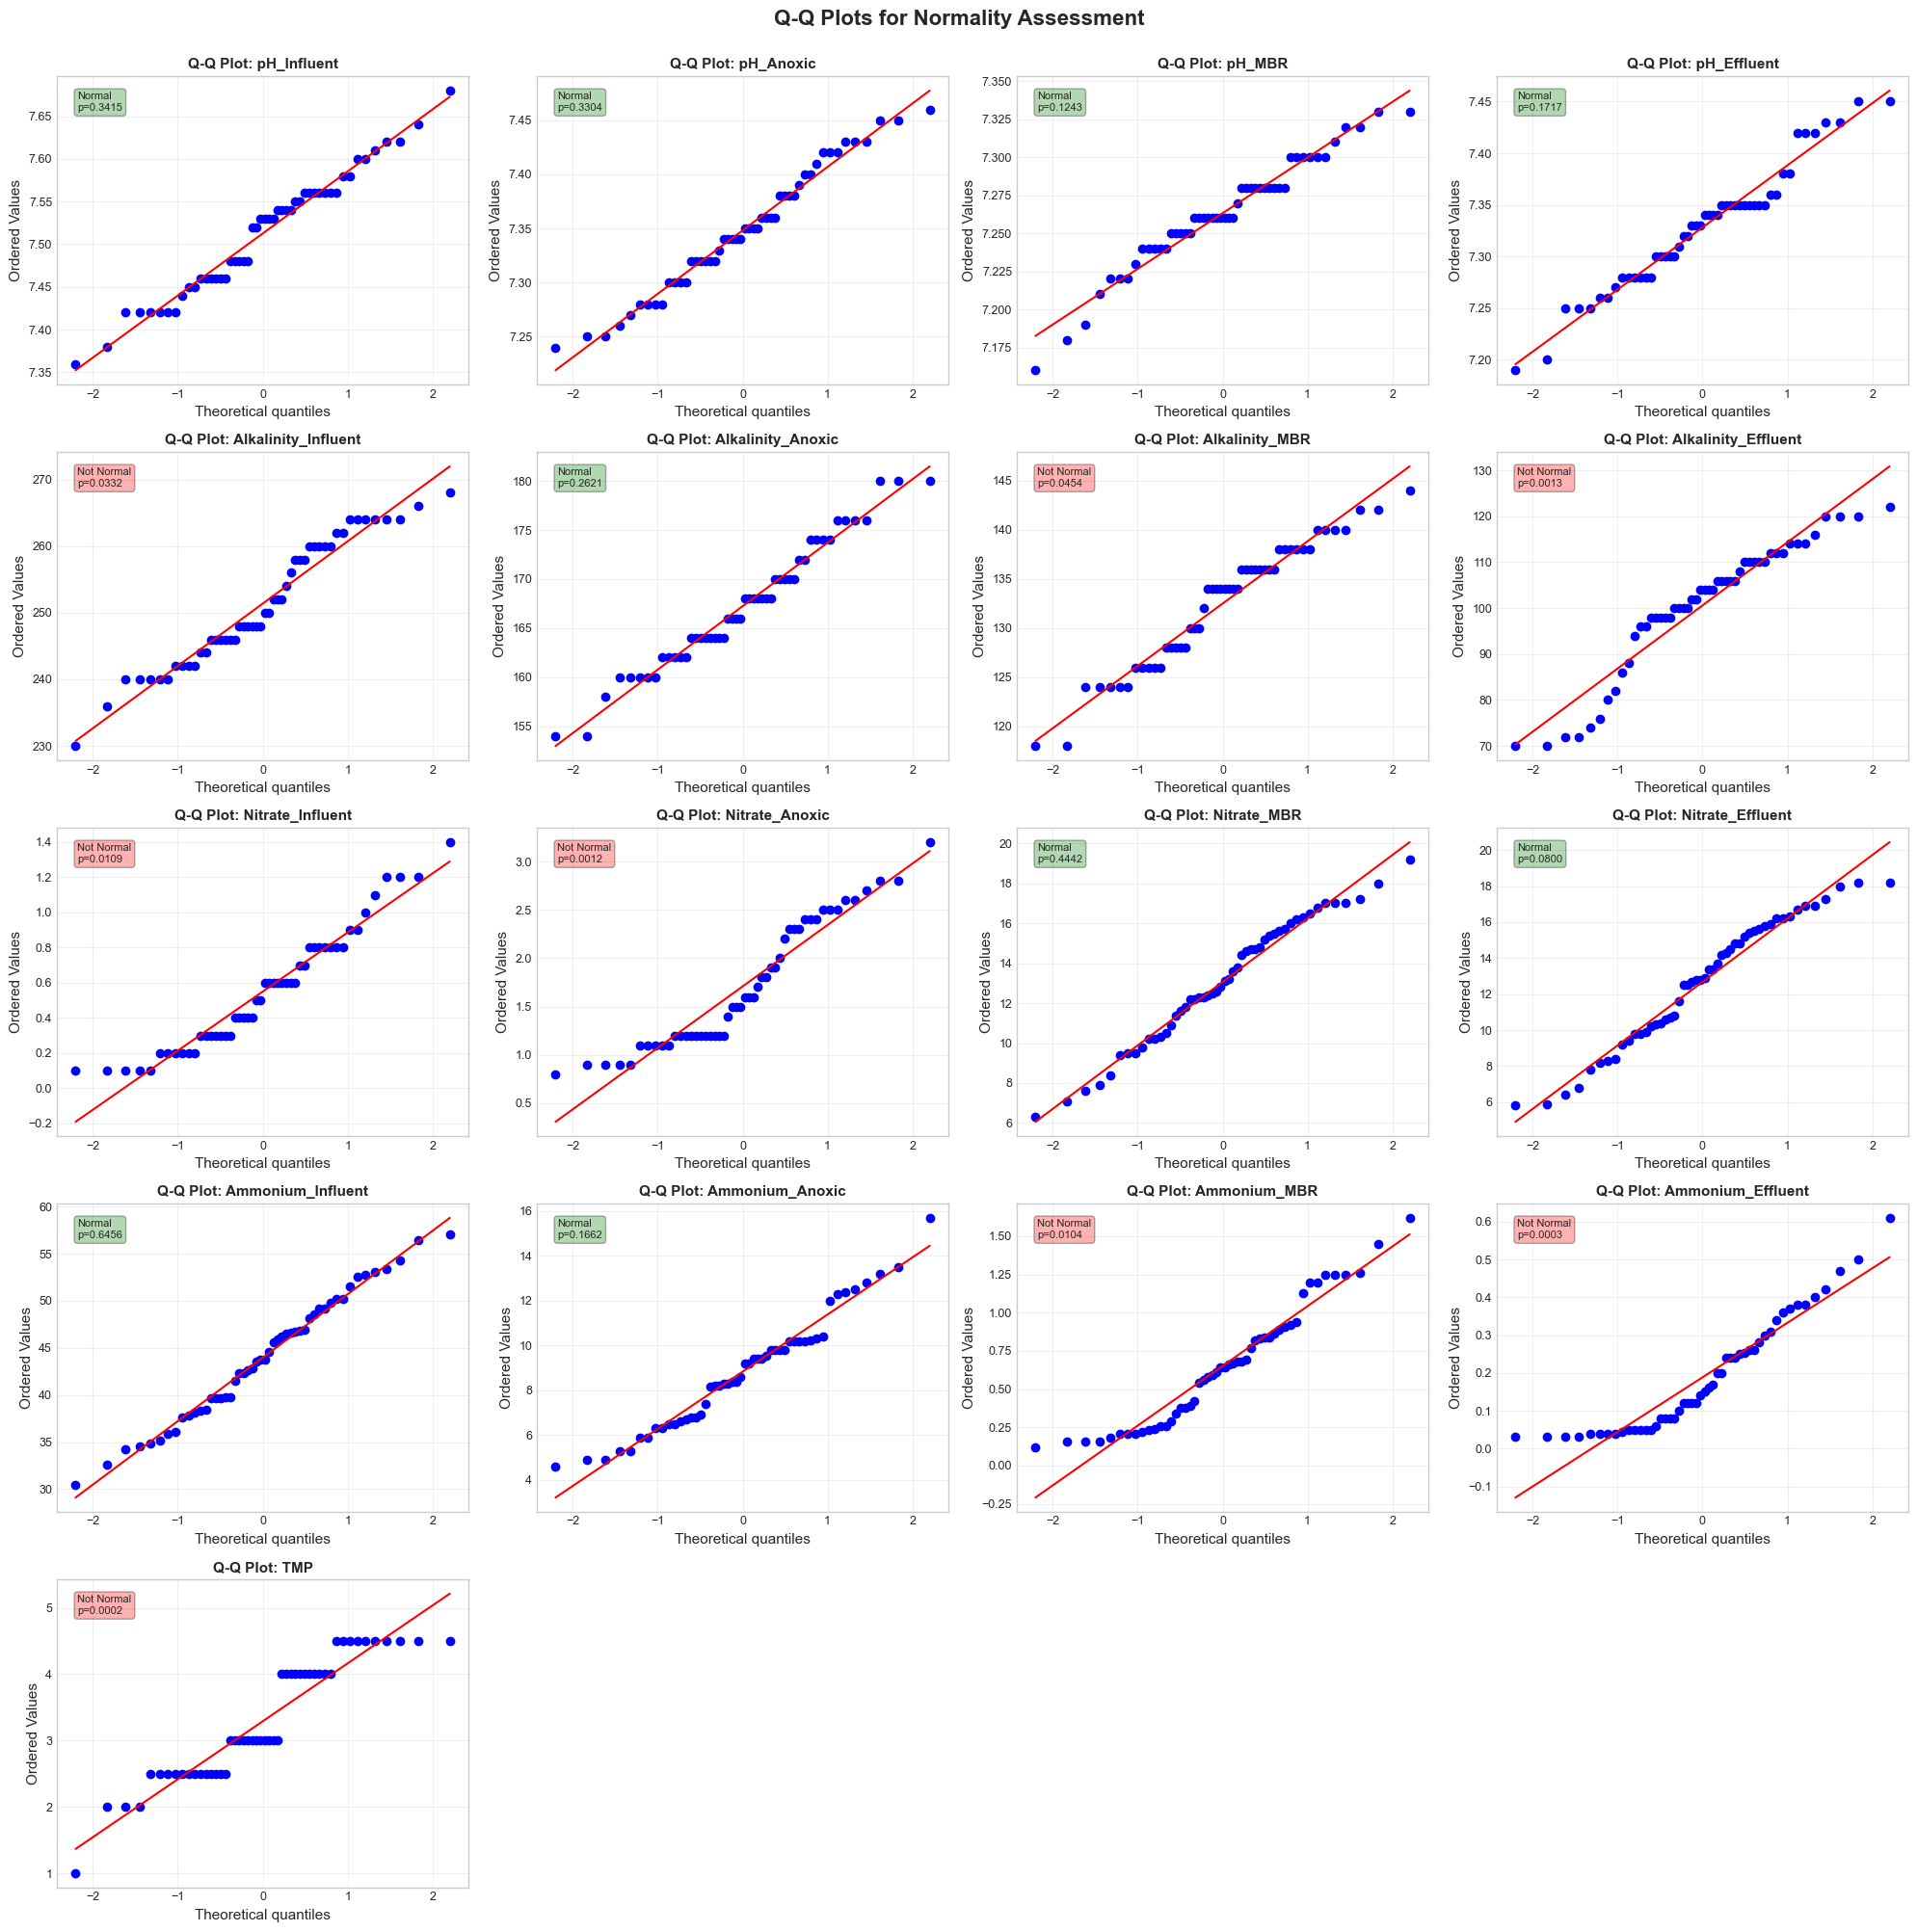

In [31]:
print("[11/12] Creating Q-Q plots...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    
    stats.probplot(df_plot[col], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {col}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add normality test result
    shapiro_stat, shapiro_p = stats.shapiro(df_plot[col])
    normal_text = 'Normal' if shapiro_p > 0.05 else 'Not Normal'
    color = 'green' if shapiro_p > 0.05 else 'red'
    
    ax.text(0.05, 0.95, f'{normal_text}\np={shapiro_p:.4f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3),
            fontsize=8)

# Hide empty subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Q-Q Plots for Normality Assessment', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('11_qq_plots_normality.png', bbox_inches='tight')
plt.show()

### FIGURE 12: FEATURE IMPORTANCE BASED ON CORRELATION

[12/12] Creating feature importance visualization...


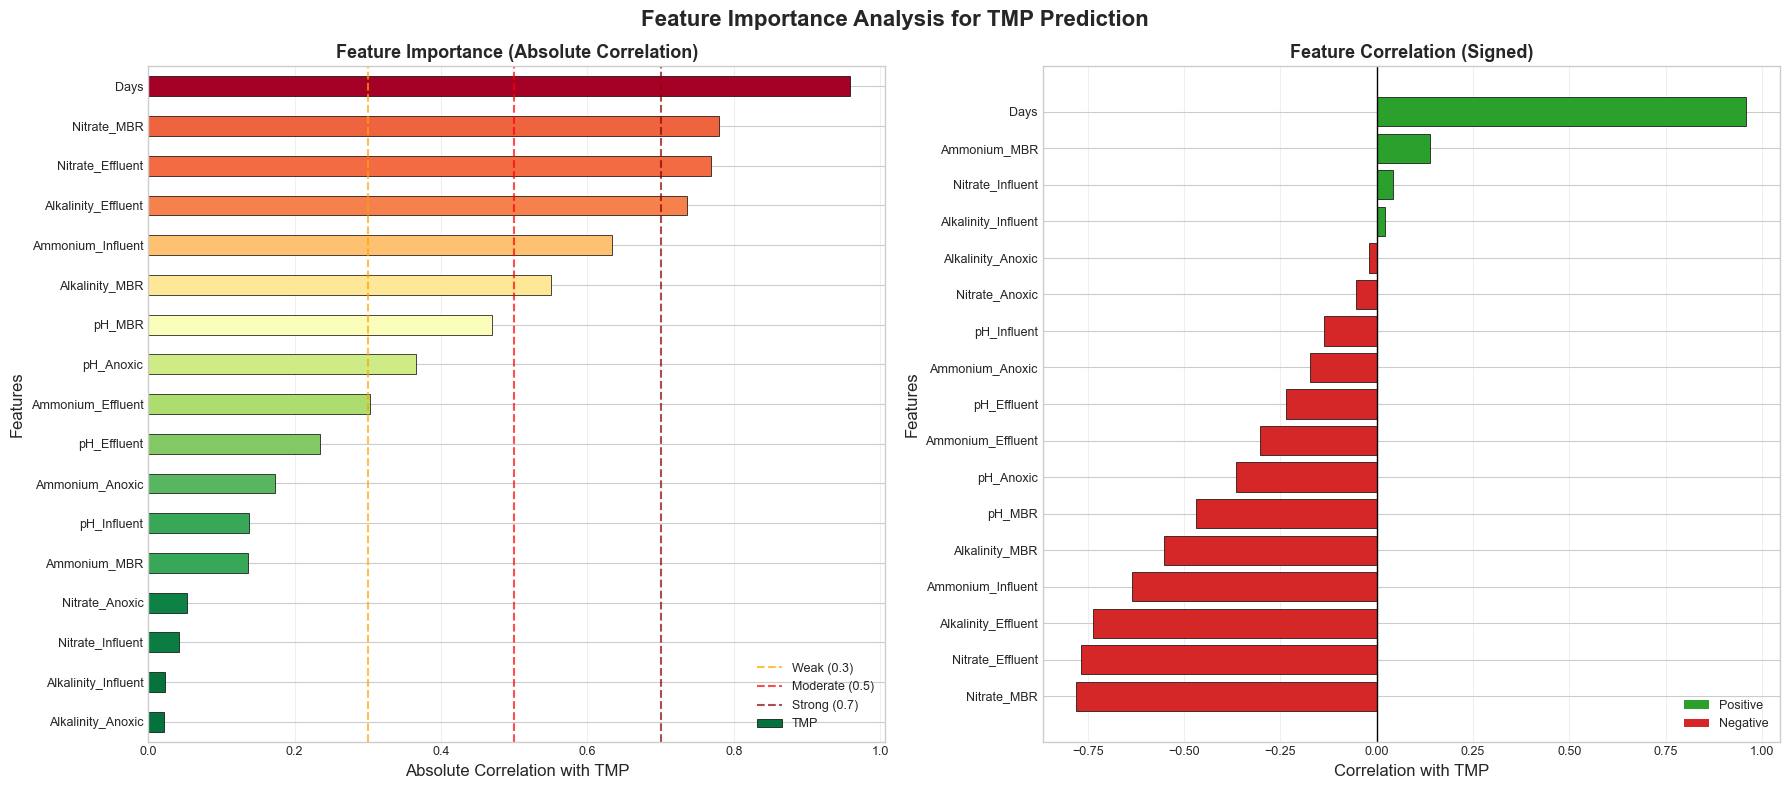

In [32]:
print("[12/12] Creating feature importance visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Absolute correlations
abs_corr = corr_matrix['TMP'].drop('TMP').abs().sort_values(ascending=True)
colors_abs = plt.cm.RdYlGn_r(abs_corr.values / abs_corr.max())

abs_corr.plot(kind='barh', ax=ax1, color=colors_abs, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Absolute Correlation with TMP', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)
ax1.set_title('Feature Importance (Absolute Correlation)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add vertical reference lines
ax1.axvline(x=0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Weak (0.3)')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Moderate (0.5)')
ax1.axvline(x=0.7, color='darkred', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong (0.7)')
ax1.legend(loc='lower right')

# Right plot: Signed correlations with color coding
signed_corr = corr_matrix['TMP'].drop('TMP').sort_values(ascending=True)
colors_signed = ['#d62728' if x < 0 else '#2ca02c' for x in signed_corr.values]

bars = ax2.barh(range(len(signed_corr)), signed_corr.values, color=colors_signed, 
                edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(signed_corr)))
ax2.set_yticklabels(signed_corr.index)
ax2.set_xlabel('Correlation with TMP', fontsize=12)
ax2.set_ylabel('Features', fontsize=12)
ax2.set_title('Feature Correlation (Signed)', fontsize=13, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ca02c', label='Positive'),
                   Patch(facecolor='#d62728', label='Negative')]
ax2.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Feature Importance Analysis for TMP Prediction', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('12_feature_importance.png', bbox_inches='tight')
plt.show()